# Performance per Salary (PPS) for NFL Skill Position Players

Research and Analysis by Robert Greenberg

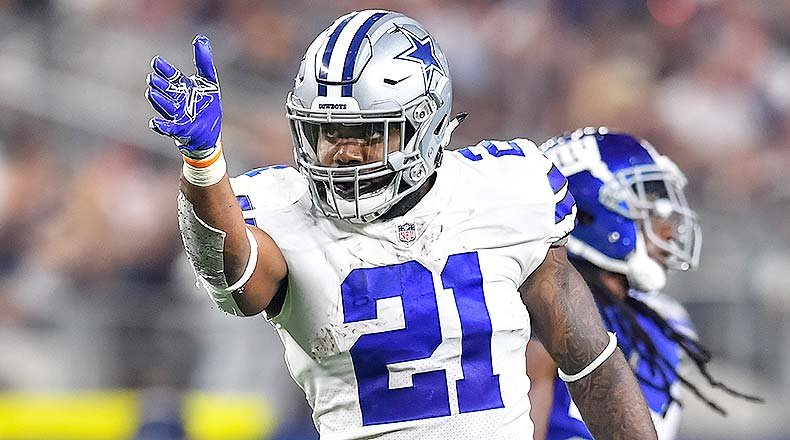

# Setup imports

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn.neighbors
import sklearn.tree
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
import statistics
from datetime import date
import calendar
from pandas import DataFrame
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from fuzzywuzzy import fuzz # use this to match, then replace 'Players', so that i can import key metrics into the same dataframe
from scipy import stats
from ggplot import *
from numpy.polynomial.polynomial import polyfit
import statistics 

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

/Users/RobertGreenberg/miniconda3/envs/comp135_env/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/RobertGreenberg/miniconda3/envs/comp135_env/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [2]:
%matplotlib inline

# Load full datasets

## 2015 RB Data

#### 2015 DATA RBS

In [3]:
RB_FA_2015 = pd.read_csv('2015_FA_RBs_Sals.csv')
RB_FA_2015['PLAYER'] = RB_FA_2015['PLAYER'].str.replace(r'[*,+]', '')
RB_FA_2015 = RB_FA_2015.rename(columns={"2016 CAP": "2015 CAP", "PLAYER": "Player"})
RB_FA_2015


RB_Rookie_2015 = pd.read_csv('2015_Drafted_RBs+Sal.csv')
RB_Rookie_2015['PLAYER'] = RB_Rookie_2015['PLAYER'].str.replace(r'[*,+]', '')
RB_Rookie_2015 = RB_Rookie_2015.rename(columns={"PLAYER": "Player"})
RB_Rookie_2015['AAV'] = RB_Rookie_2015['TOTAL VALUE']/RB_Rookie_2015['YRS']
RB_Rookie_2015.dropna(axis=0, how='all')


RUSH_FO_2015 = pd.read_csv('RB_2015_FO_Stats.csv')
RUSH_FO_2015['Player'] = RUSH_FO_2015['Player'].str.replace(r'[*,+]', '')

REC_FO_2015 = pd.read_csv('REC_2015_FO_Stats.csv')
REC_FO_2015['Player'] = REC_FO_2015['Player'].str.replace(r'[*,+]', '')

AV_2015 = pd.read_csv('2015_AV.csv')
AV_2015['Player'] = AV_2015['Player'].str.replace(r'[*,+]', '')

#RB_FA_2015

In [4]:
# need to also add DYAR for receiving !!!!!
FA_Rush_2015 = RB_FA_2015.merge(RUSH_FO_2015, how='left',on='Player')
FA_Rush_2015 = FA_Rush_2015.merge(REC_FO_2015, how='left',on='Player')


FA_Rush_2015 = FA_Rush_2015.fillna(value = 0.)
FA_Rush_2015['DYAR'] = FA_Rush_2015['DYAR_x'] + FA_Rush_2015['DYAR_y']


# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2017[Rush_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
FA_Rush_2015 = FA_Rush_2015.dropna(subset=['DYAR'])
FA_Rush_2015 = FA_Rush_2015.loc[:, ~FA_Rush_2015.columns.str.contains('^Unnamed')]
FA_Rush_2015.sort_values(by=['DYAR'], ascending=False)
#print(FA_Rush_2015)


FA_Rush_2015['label'] = ((FA_Rush_2015['Player'])+ " " + '2015')
FA_Rush_2015['PPM'] = 1000000*(FA_Rush_2015['DYAR']/FA_Rush_2015['AAV'])
FA_Rush_2015['%GTD'] = FA_Rush_2015['TOTAL GTD']/FA_Rush_2015['DOLLARS']



In [49]:
print(FA_Rush_2015['AAV'].quantile([0, 0.25, 0.5, 0.75, 1.]))
print(FA_Rush_2015['PPM'].quantile([0, 0.25, 0.5, 0.75, 1.]))

conditions = [
    (FA_Rush_2015['AAV'] >= 3666667.0), #make 75th percentile or less, 75th in DYAR, above 50th in PPM
    (FA_Rush_2015['AAV'] >= 2000000.0) & (FA_Rush_2015['AAV'] <= 3666667.0),
    (FA_Rush_2015['AAV'] >= 870000.0) & (FA_Rush_2015['AAV'] <= 2000000.0),
    (FA_Rush_2015['AAV'] >= 745000.0) & (FA_Rush_2015['AAV'] <= 870000.0),
    ]


choices = [1, 2, 3, 4]

FA_Rush_2015['Tier'] = np.select(conditions, choices)

print(FA_Rush_2015)


0.00     745000.0
0.25     870000.0
0.50    2000000.0
0.75    3666667.0
1.00    8000000.0
Name: AAV, dtype: float64
0.00    -75.000000
0.25     -6.750000
0.50      1.500000
0.75     27.206476
1.00    146.500000
Name: PPM, dtype: float64
                        Player POS.  AGE FROM   TO  YRS   DOLLARS      AAV  \
0      DeMarco Murray\MurrDe00   RB   27  DAL  PHI    5  40000000  8000000   
1        C.J. Spiller\SpilC.00   RB   28  BUF   NO    4  16000000  4000000   
2        Shane Vereen\VereSh00   RB   26   NE  NYG    3  12350000  4116667   
3          Frank Gore\GoreFr00   RB   32   SF  IND    3  12000000  4000000   
4        Ryan Mathews\MathRy00   RB   27   SD  PHI    3  11000000  3666667   
5      Justin Forsett\ForsJu00   RB   29  BAL  BAL    3   9000000  3000000   
6   DeAngelo Williams\WillDe02   RB   32  CAR  PIT    2   4000000  2000000   
7     Darren McFadden\McFaDa00   RB   28  OAK  DAL    2   3000000  1500000   
8         Reggie Bush\BushRe00   RB   30  DET   SF    1   250

In [50]:
# need to also add DYAR for receiving !!!!!
Rookie_Rush_2015 = RB_Rookie_2015.merge(RUSH_FO_2015, how='left',on='Player')
Rookie_Rush_2015 = Rookie_Rush_2015.merge(REC_FO_2015, how='left',on='Player')


Rookie_Rush_2015 = Rookie_Rush_2015.fillna(value = 0.)
Rookie_Rush_2015['DYAR'] = Rookie_Rush_2015['DYAR_x'] + Rookie_Rush_2015['DYAR_y']



# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2017[Rush_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
#Rookie_Rush_2015 = Rookie_Rush_2015.dropna(subset=['DYAR'])
Rookie_Rush_2015 = Rookie_Rush_2015.loc[:, ~Rookie_Rush_2015.columns.str.contains('^Unnamed')]
Rookie_Rush_2015.sort_values(by=['DYAR'], ascending=False)
#print(Rookie_Rush_2015)


Rookie_Rush_2015['label'] = ((Rookie_Rush_2015['Player'])+ " " + '2015')
Rookie_Rush_2015['PPM'] = 1000000*(Rookie_Rush_2015['DYAR']/Rookie_Rush_2015['AAV'])
Rookie_Rush_2015['%GTD'] = Rookie_Rush_2015['SIGNING BONUS']/Rookie_Rush_2015['TOTAL VALUE']
#Rookie_Rush_2015['label']

### 2016 RB DATA

In [7]:
RB_FA_2016 = pd.read_csv('2016_FA_RBs_Sals.csv')
RB_FA_2016['PLAYER'] = RB_FA_2016['PLAYER'].str.replace(r'[*,+]', '')
RB_FA_2016 = RB_FA_2016.rename(columns={"2016 CAP": "2016 CAP", "PLAYER": "Player"})
RB_FA_2016


RB_Rookie_2016 = pd.read_csv('2016_Drafted_RBs+Sal.csv')
RB_Rookie_2016['PLAYER'] = RB_Rookie_2016['PLAYER'].str.replace(r'[*,+]', '')
RB_Rookie_2016 = RB_Rookie_2016.rename(columns={"PLAYER": "Player"})
RB_Rookie_2016['AAV'] = RB_Rookie_2016['TOTAL VALUE']/RB_Rookie_2016['YRS']
RB_Rookie_2016.dropna(axis=0, how='all')


RUSH_FO_2016 = pd.read_csv('RB_2016_FO_Stats.csv')
RUSH_FO_2016['Player'] = RUSH_FO_2016['Player'].str.replace(r'[*,+]', '')

REC_FO_2016 = pd.read_csv('REC_2016_FO_Stats.csv')
REC_FO_2016['Player'] = REC_FO_2016['Player'].str.replace(r'[*,+]', '')

AV_2016 = pd.read_csv('2016_AV.csv')
AV_2016['Player'] = AV_2016['Player'].str.replace(r'[*,+]', '')
#RB_Rookie_2016

In [8]:
#Rushing_2017
#FA_Rush_2016 = RUSH_FO_2016.merge(AV_2016, how='left',on='Player')
FA_Rush_2016 = RB_FA_2016.merge(RUSH_FO_2016, how='left',on='Player')
FA_Rush_2016 = FA_Rush_2016.merge(REC_FO_2016, how='left',on='Player')


FA_Rush_2016 = FA_Rush_2016.fillna(value = 0.)
FA_Rush_2016['DYAR'] = FA_Rush_2016['DYAR_x'] + FA_Rush_2016['DYAR_y']


# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2017[Rush_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
FA_Rush_2016 = FA_Rush_2016.dropna(subset=['DYAR'])
FA_Rush_2016 = FA_Rush_2016.loc[:, ~FA_Rush_2016.columns.str.contains('^Unnamed')]
FA_Rush_2016.sort_values(by=['DYAR'], ascending=False)
#print(FA_Rush_2016)

FA_Rush_2016['label'] = ((FA_Rush_2016['Player'])  + " " + '2016')
FA_Rush_2016['PPM'] = 1000000*(FA_Rush_2016['DYAR']/FA_Rush_2016['AAV'])
FA_Rush_2016['%GTD'] = FA_Rush_2016['TOTAL GTD']/FA_Rush_2016['DOLLARS']






In [9]:
print(FA_Rush_2016['AAV'].quantile([0, 0.25, 0.5, 0.75, 1.]))

conditions = [
    (FA_Rush_2016['AAV'] >= 3562500.0), #make 75th percentile or less, 75th in DYAR, above 50th in PPM
    (FA_Rush_2016['AAV'] >= 1500000.0) & (FA_Rush_2016['AAV'] <= 3562500.0),
    (FA_Rush_2016['AAV'] >= 1193750.0) & (FA_Rush_2016['AAV'] <=  1500000.0),
    (FA_Rush_2016['AAV'] >= 885000.0) & (FA_Rush_2016['AAV'] <= 1193750.0),
    ]


choices = [1, 2, 3, 4]

FA_Rush_2016['Tier'] = np.select(conditions, choices)

#print(FA_Rush_2016)


0.00     885000.0
0.25    1193750.0
0.50    1500000.0
0.75    3562500.0
1.00    6500000.0
Name: AAV, dtype: float64


In [10]:
# need to also add DYAR for receiving !!!!!
Rookie_Rush_2016 = RB_Rookie_2016.merge(RUSH_FO_2016, how='left',on='Player')
Rookie_Rush_2016 = Rookie_Rush_2016.merge(REC_FO_2016, how='left',on='Player')


Rookie_Rush_2016 = Rookie_Rush_2016.fillna(value = 0.)
Rookie_Rush_2016['DYAR'] = Rookie_Rush_2016['DYAR_x'] + Rookie_Rush_2016['DYAR_y']

#Rookie_Rush_2016['PPM'] = Rookie_Rush_2016['DYAR']/Rookie_Rush_2016['AAV']



# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2017[Rush_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
Rookie_Rush_2016 = Rookie_Rush_2016.dropna(subset=['DYAR'])
Rookie_Rush_2016 = Rookie_Rush_2016.loc[:, ~Rookie_Rush_2016.columns.str.contains('^Unnamed')]
Rookie_Rush_2016.sort_values(by=['DYAR'], ascending=False)
#print(Rookie_Rush_2016)


Rookie_Rush_2016['label'] = ((Rookie_Rush_2016['Player'])+ " " + '2016')
Rookie_Rush_2016['PPM'] = 1000000*(Rookie_Rush_2016['DYAR']/Rookie_Rush_2016['AAV'])
Rookie_Rush_2016['%GTD'] = Rookie_Rush_2016['SIGNING BONUS']/Rookie_Rush_2016['TOTAL VALUE']

#Rookie_Rush_2016['label']

### 2017 RB data

In [11]:
RB_FA_2017 = pd.read_csv('2017_FA_RBs_Sals.csv')
RB_FA_2017['PLAYER'] = RB_FA_2017['PLAYER'].str.replace(r'[*,+]', '')
RB_FA_2017 = RB_FA_2017.rename(columns={"2017 CAP": "2017 CAP", "PLAYER": "Player"})
RB_FA_2017


RB_Rookie_2017 = pd.read_csv('2017_Drafted_RBs+.csv')
RB_Rookie_2017['PLAYER'] = RB_Rookie_2017['PLAYER'].str.replace(r'[*,+]', '')
RB_Rookie_2017 = RB_Rookie_2017.rename(columns={"PLAYER": "Player"})
RB_Rookie_2017['AAV'] = RB_Rookie_2017['TOTAL VALUE']/RB_Rookie_2017['YRS']
RB_Rookie_2017.dropna(axis=0, how='all')


RUSH_FO_2017 = pd.read_csv('RB_2017_FO_Stats.csv')
RUSH_FO_2017['Player'] = RUSH_FO_2017['Player'].str.replace(r'[*,+]', '')

REC_FO_2017 = pd.read_csv('REC_2017_FO_Stats.csv')
REC_FO_2017['Player'] = REC_FO_2017['Player'].str.replace(r'[*,+]', '')

AV_2017 = pd.read_csv('AV_2017.csv')
AV_2017['Player'] = AV_2017['Player'].str.replace(r'[*,+]', '')
#RB_Rookie_2017
#RB_FA_2017

In [12]:
#Rushing_2017
#FA_Rush_2017 = RUSH_FO_2017.merge(AV_2017, how='left',on='Player')
FA_Rush_2017 = RB_FA_2017.merge(RUSH_FO_2017, how='left',on='Player')
FA_Rush_2017 = FA_Rush_2017.merge(REC_FO_2017, how='left',on='Player')


FA_Rush_2017 = FA_Rush_2017.fillna(value = 0.)
FA_Rush_2017['DYAR'] = FA_Rush_2017['DYAR_x'] + FA_Rush_2017['DYAR_y']


 
# Delete these row indexes from dataFrame
#FA_Rush_2017 = FA_Rush_2017.dropna(subset=['DYAR'])
FA_Rush_2017 = FA_Rush_2017.loc[:, ~FA_Rush_2017.columns.str.contains('^Unnamed')]
FA_Rush_2017.sort_values(by=['DYAR'], ascending=False)
#FA_Rush_2017.to_csv('Fucked.csv')

FA_Rush_2017['label'] = ((FA_Rush_2017['Player'])  + " " + '2017')
FA_Rush_2017['PPM'] = 1000000*(FA_Rush_2017['DYAR']/FA_Rush_2017['AAV'])
FA_Rush_2017['%GTD'] = FA_Rush_2017['TOTAL GTD']/FA_Rush_2017['DOLLARS']


In [13]:
print(FA_Rush_2017['AAV'].quantile([0, 0.25, 0.5, 0.75, 1.]))

conditions = [
    (FA_Rush_2017['AAV'] >= 2608333.25), #make 75th percentile or less, 75th in DYAR, above 50th in PPM
    (FA_Rush_2017['AAV'] >= 1125000.00) & (FA_Rush_2017['AAV'] <= 2608333.25),
    (FA_Rush_2017['AAV'] >= 855000.00) & (FA_Rush_2017['AAV'] <=  1125000.00),
    (FA_Rush_2017['AAV'] >= 775000.00) & (FA_Rush_2017['AAV'] <= 855000.00),
    ]


choices = [1, 2, 3, 4]

FA_Rush_2017['Tier'] = np.select(conditions, choices)

print(FA_Rush_2017)


0.00     775000.00
0.25     855000.00
0.50    1125000.00
0.75    2608333.25
1.00    5000000.00
Name: AAV, dtype: float64
                        Player POS.  AGE FROM   TO  YRS   DOLLARS      AAV  \
0     Latavius Murray\MurrLa00   RB   26  OAK  MIN    3  15000000  5000000   
1      Danny Woodhead\WoodDa02   RB   32  LAC  BAL    3   8800000  2933333   
2     Adrian Peterson\PeteAd01   RB   32  MIN   NO    2   7000000  3500000   
3          Eddie Lacy\LacyEd00   RB   26   GB  SEA    1   4250000  4250000   
4    Jacquizz Rodgers\RodgJa00   RB   27   TB   TB    2   3300000  1650000   
5        Rex Burkhead\BurkRe00   RB   27  CIN   NE    1   3150000  3150000   
6       Robert Turbin\TurbRo00   RB   27  IND  IND    2   2700000  1350000   
7      Jamaal Charles\CharJa00   RB   30   KC  DEN    1   2500000  2500000   
8        Lance Dunbar\DunbLa00   RB   27  DAL  LAR    1   1500000  1500000   
9   LeGarrette Blount\BlouLe00   RB   30   NE  PHI    1   1250000  1250000   
10      Chris Johnson

In [14]:
# need to also add DYAR for receiving !!!!!
Rookie_Rush_2017 = RB_Rookie_2017.merge(RUSH_FO_2017, how='left',on='Player')
Rookie_Rush_2017 = Rookie_Rush_2017.merge(REC_FO_2017, how='left',on='Player')


Rookie_Rush_2017 = Rookie_Rush_2017.fillna(value = 0.)
Rookie_Rush_2017['DYAR'] = Rookie_Rush_2017['DYAR_x'] + Rookie_Rush_2017['DYAR_y']

Rookie_Rush_2017['assd'] = ((Rookie_Rush_2017['DYAR'])/(Rookie_Rush_2017['AAV']))

# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2017[Rush_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
Rookie_Rush_2017 = Rookie_Rush_2017.dropna(subset=['DYAR'])
Rookie_Rush_2017 = Rookie_Rush_2017.loc[:, ~Rookie_Rush_2017.columns.str.contains('^Unnamed')]
Rookie_Rush_2017.sort_values(by=['DYAR'], ascending=False)


Rookie_Rush_2017['label'] = ((Rookie_Rush_2017['Player'])+ " " + '2017')
Rookie_Rush_2017['PPM'] = (1000000*(Rookie_Rush_2017['DYAR'])/(Rookie_Rush_2017['AAV']))
Rookie_Rush_2017['%GTD'] = Rookie_Rush_2017['SIGNING BONUS']/Rookie_Rush_2017['TOTAL VALUE']



### 2018 RB Data

In [15]:
RB_FA_2018 = pd.read_csv('2018_FA_RBs_Sals.csv')
RB_FA_2018['PLAYER'] = RB_FA_2018['PLAYER'].str.replace(r'[*,+]', '')
RB_FA_2018 = RB_FA_2018.rename(columns={"2017 CAP": "2018 CAP", "PLAYER": "Player"})
RB_FA_2018


RB_Rookie_2018 = pd.read_csv('2018_Drafted_RBs+Sal.csv')
RB_Rookie_2018['PLAYER'] = RB_Rookie_2018['PLAYER'].str.replace(r'[*,+]', '')
RB_Rookie_2018 = RB_Rookie_2018.rename(columns={"PLAYER": "Player"})
RB_Rookie_2018['AAV'] = RB_Rookie_2018['TOTAL VALUE']/RB_Rookie_2018['YRS']
RB_Rookie_2018.dropna(axis=0, how='all')


RUSH_FO_2018 = pd.read_csv('RB_2018_FO_Stats.csv')
RUSH_FO_2018['Player'] = RUSH_FO_2018['Player'].str.replace(r'[*,+]', '')

REC_FO_2018 = pd.read_csv('REC_2018_FO_Stats.csv')
REC_FO_2018['Player'] = REC_FO_2018['Player'].str.replace(r'[*,+]', '')

AV_2018 = pd.read_csv('AV_2018.csv')
AV_2018['Player'] = AV_2018['Player'].str.replace(r'[*,+]', '')
#RB_Rookie_2018
#RB_FA_2018

In [16]:
#Rushing_2018
#FA_Rush_2018 = RUSH_FO_2018.merge(AV_2018, how='left',on='Player')
FA_Rush_2018 = RB_FA_2018.merge(RUSH_FO_2018, how='left',on='Player')
FA_Rush_2018 = FA_Rush_2018.merge(REC_FO_2018, how='left',on='Player')


FA_Rush_2018 = FA_Rush_2018.fillna(value = 0.)
FA_Rush_2018['DYAR'] = FA_Rush_2018['DYAR_x'] + FA_Rush_2018['DYAR_y']

# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2018[Rush_2018['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
FA_Rush_2018 = FA_Rush_2018.dropna(subset=['DYAR'])
FA_Rush_2018 = FA_Rush_2018.loc[:, ~FA_Rush_2018.columns.str.contains('^Unnamed')]
FA_Rush_2018.sort_values(by=['DYAR'], ascending=False)
#print(FA_Rush_2018)

FA_Rush_2018['label'] = ((FA_Rush_2018['Player']) + " " + '2018')
FA_Rush_2018['PPM'] = 1000000*(FA_Rush_2018['DYAR']/FA_Rush_2018['AAV'])
FA_Rush_2018['%GTD'] = FA_Rush_2018['TOTAL GTD']/FA_Rush_2018['DOLLARS']

In [17]:
print(FA_Rush_2018['AAV'].quantile([0, 0.25, 0.5, 0.75, 1.]))

conditions = [
    (FA_Rush_2018['AAV'] >= 1750000.0), #make 75th percentile or less, 75th in DYAR, above 50th in PPM
    (FA_Rush_2018['AAV'] >= 1050000.0) & (FA_Rush_2018['AAV'] <= 1750000.0),
    (FA_Rush_2018['AAV'] >= 855000.0) & (FA_Rush_2018['AAV'] <=  1050000.0),
    (FA_Rush_2018['AAV'] >= 705000.0) & (FA_Rush_2018['AAV'] <= 855000.0),
    ]


choices = [1, 2, 3, 4]

FA_Rush_2018['Tier'] = np.select(conditions, choices)

print(FA_Rush_2018)


0.00     705000.0
0.25     855000.0
0.50    1050000.0
0.75    1750000.0
1.00    7500000.0
Name: AAV, dtype: float64
                        Player POS.  AGE FROM   TO  YRS     DOLLARS  \
0              Jerick McKinnon   RB   26  MIN   SF    4  30000000.0   
1          Dion Lewis\LewiDi00   RB   27   NE  TEN    4  19800000.0   
2         Carlos Hyde\HydeCa00   RB   26   SF  CLE    3  15250000.0   
3      Isaiah Crowell\CrowIs00   RB   25  CLE  NYJ    3  12000000.0   
4        Rex Burkhead\BurkRe00   RB   28   NE   NE    3   9750000.0   
5    Jonathan Stewart\StewJo00   RB   31  CAR  NYG    2   6800000.0   
6         Chris Ivory\IvorCh00   RB   30  JAC  BUF    2   5500000.0   
7   LeGarrette Blount\BlouLe00   RB   31  PHI  DET    1   2000000.0   
8       C.J. Anderson\AndeC.00   RB   27  DEN  CAR    1   1750000.0   
9         Jeremy Hill\HillJe01   RB   25  CIN   NE    1   1500000.0   
10        Doug Martin\MartDo00   RB   29   TB  OAK    1   1475000.0   
11     Darren Sproles\SproDa00  

In [18]:
# need to also add DYAR for receiving !!!!!
Rookie_Rush_2018 = RB_Rookie_2018.merge(RUSH_FO_2018, how='left',on='Player')
Rookie_Rush_2018 = Rookie_Rush_2018.merge(REC_FO_2018, how='left',on='Player')


Rookie_Rush_2018 = Rookie_Rush_2018.fillna(value = 0.)
Rookie_Rush_2018['DYAR'] = Rookie_Rush_2018['DYAR_x'] + Rookie_Rush_2018['DYAR_y']





# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2017[Rush_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
Rookie_Rush_2018 = Rookie_Rush_2018.dropna(subset=['DYAR'])
Rookie_Rush_2018 = Rookie_Rush_2018.loc[:, ~Rookie_Rush_2018.columns.str.contains('^Unnamed')]
Rookie_Rush_2018.sort_values(by=['DYAR'], ascending=False)
#print(Rookie_Rush_2018)


Rookie_Rush_2018['label'] = ((Rookie_Rush_2018['Player'])+ " " + '2018')
Rookie_Rush_2018['PPM'] = 1000000*(Rookie_Rush_2018['DYAR']/Rookie_Rush_2018['AAV'])
Rookie_Rush_2018['%GTD'] = Rookie_Rush_2018['SIGNING BONUS']/Rookie_Rush_2018['TOTAL VALUE']


### 2019 RB Data

In [19]:
RB_FA_2019 = pd.read_csv('2019_FA_RBs_Sals.csv')
RB_FA_2019['PLAYER'] = RB_FA_2019['PLAYER'].str.replace(r'[*,+]', '')
RB_FA_2019 = RB_FA_2019.rename(columns={"2019 CAP": "2019 CAP", "PLAYER": "Player"})
RB_FA_2019


RB_Rookie_2019 = pd.read_csv('2019_Drafted_RBs+Sals.csv')
RB_Rookie_2019['PLAYER'] = RB_Rookie_2019['PLAYER'].str.replace(r'[*,+]', '')
RB_Rookie_2019 = RB_Rookie_2019.rename(columns={"PLAYER": "Player"})
RB_Rookie_2019['AAV'] = RB_Rookie_2019['TOTAL VALUE']/RB_Rookie_2019['YRS']
RB_Rookie_2019.dropna(axis=0, how='all')


RUSH_FO_2019 = pd.read_csv('RB_2019_FO_Stats.csv')
RUSH_FO_2019['Player'] = RUSH_FO_2019['Player'].str.replace(r'[*,+]', '')

REC_FO_2019 = pd.read_csv('REC_2019_FO_Stats.csv')
REC_FO_2019['Player'] = REC_FO_2019['Player'].str.replace(r'[*,+]', '')

AV_2019 = pd.read_csv('AV_2019.csv')
AV_2019['Player'] = AV_2019['Player'].str.replace(r'[*,+]', '')
#RB_Rookie_2019

In [20]:
#Rushing_2017
#FA_Rush_2019 = RUSH_FO_2019.merge(AV_2019, how='left',on='Player')
FA_Rush_2019 = RB_FA_2019.merge(RUSH_FO_2019, how='left',on='Player')
FA_Rush_2019 = FA_Rush_2019.merge(REC_FO_2019, how='left',on='Player')


FA_Rush_2019 = FA_Rush_2019.fillna(value = 0.)
FA_Rush_2019['DYAR'] = FA_Rush_2019['DYAR_x'] + FA_Rush_2019['DYAR_y']


# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2017[Rush_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
FA_Rush_2019 = FA_Rush_2019.dropna(subset=['DYAR'])
FA_Rush_2019 = FA_Rush_2019.loc[:, ~FA_Rush_2019.columns.str.contains('^Unnamed')]
FA_Rush_2019.sort_values(by=['DYAR'], ascending=False)
#print(FA_Rush_2019)

FA_Rush_2019['label'] = ((FA_Rush_2019['Player'])  + " " + '2019')
FA_Rush_2019['PPM'] = 1000000*(FA_Rush_2019['DYAR']/FA_Rush_2019['AAV'])
FA_Rush_2019['%GTD'] = FA_Rush_2019['TOTAL GTD']/FA_Rush_2019['DOLLARS']





In [21]:
print(FA_Rush_2019['AAV'].quantile([0, 0.25, 0.5, 0.75, 1.]))


#Tier is what you are paid, 1 tier would be a RB who makes more than 75th% of money 
conditions = [
    (FA_Rush_2019['AAV'] >= 3562500.0), #make 75th percentile or less, 75th in DYAR, above 50th in PPM
    (FA_Rush_2019['AAV'] >= 1500000.0) & (FA_Rush_2019['AAV'] <= 3562500.0),
    (FA_Rush_2019['AAV'] >= 1193750.0) & (FA_Rush_2019['AAV'] <=  1500000.0),
    (FA_Rush_2019['AAV'] >= 885000.0) & (FA_Rush_2019['AAV'] <= 1193750.0),
    ]


choices = [1, 2, 3, 4]

FA_Rush_2019['Tier'] = np.select(conditions, choices)

#print(FA_Rush_2019)


0.00     625000.0
0.25    1500000.0
0.50    4875000.0
0.75    6000000.0
1.00    8000000.0
Name: AAV, dtype: float64


In [22]:
# need to also add DYAR for receiving !!!!!
Rookie_Rush_2019 = RB_Rookie_2019.merge(RUSH_FO_2019, how='left',on='Player')
Rookie_Rush_2019 = Rookie_Rush_2019.merge(REC_FO_2019, how='left',on='Player')


Rookie_Rush_2019 = Rookie_Rush_2019.fillna(value = 0.)
Rookie_Rush_2019['DYAR'] = Rookie_Rush_2019['DYAR_x'] + Rookie_Rush_2019['DYAR_y']

#Rookie_Rush_2019['PPM'] = Rookie_Rush_2019['DYAR']/Rookie_Rush_2019['AAV']



# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2017[Rush_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
Rookie_Rush_2019 = Rookie_Rush_2019.dropna(subset=['DYAR'])
Rookie_Rush_2019 = Rookie_Rush_2019.loc[:, ~Rookie_Rush_2019.columns.str.contains('^Unnamed')]
Rookie_Rush_2019.sort_values(by=['DYAR'], ascending=False)
#print(Rookie_Rush_2019)


Rookie_Rush_2019['label'] = ((Rookie_Rush_2019['Player'])+ " " + '2019')
Rookie_Rush_2019['PPM'] = 1000000*(Rookie_Rush_2019['DYAR']/Rookie_Rush_2019['AAV'])
Rookie_Rush_2019['%GTD'] = Rookie_Rush_2019['SIGNING BONUS']/Rookie_Rush_2019['TOTAL VALUE']

#Rookie_Rush_2019['label']

## Some Statistics 

In [23]:
# MEANS of Rookies vs. FA's 

In [24]:
v = pd.concat([FA_Rush_2015['DYAR'],FA_Rush_2016['DYAR'],FA_Rush_2017['DYAR'],FA_Rush_2018['DYAR'],FA_Rush_2019['DYAR']])
w = pd.concat([FA_Rush_2015['AAV'],FA_Rush_2016['AAV'],FA_Rush_2017['AAV'],FA_Rush_2018['AAV'],FA_Rush_2019['AAV'] ])

k = pd.concat([FA_Rush_2015['PPM'],FA_Rush_2016['PPM'],FA_Rush_2017['PPM'],FA_Rush_2018['PPM'],FA_Rush_2019['PPM'] ])
f = pd.concat([Rookie_Rush_2015['PPM'],Rookie_Rush_2016['PPM'],Rookie_Rush_2017['PPM'],Rookie_Rush_2018['PPM'],Rookie_Rush_2019['PPM'] ])

x = pd.concat([Rookie_Rush_2015['DYAR'],Rookie_Rush_2016['DYAR'],Rookie_Rush_2017['DYAR'],Rookie_Rush_2018['DYAR'],Rookie_Rush_2019['DYAR'] ])
z = pd.concat([Rookie_Rush_2015['AAV'],Rookie_Rush_2016['AAV'],Rookie_Rush_2017['AAV'],Rookie_Rush_2018['AAV'],Rookie_Rush_2019['AAV'] ])

print(Rookie_Rush_2017['AAV'])

print("FA RB DYAR Average: ", statistics.mean(v))
print("Rookie RB DYAR Average: ", statistics.mean(x))

print("Difference: ", statistics.mean(v)-  statistics.mean(x))

print('\n')


print("FA RB DYAR median: ", statistics.median(v))
print("Rookie RB DYAR median: ", statistics.median(x))

print("Difference: ", statistics.median(v)-  statistics.median(x))

print('\n')

print("FA RB AAV median: ", statistics.median(w))
print("Rookie RB AAV median: ", statistics.median(z))

print("Difference: ", statistics.median(w)-  statistics.median(z))

print('\n')

print("FA RB AAV mean: ", statistics.mean(w))
print("Rookie RB AAV mean: ", statistics.mean(z))

print("Difference: ", statistics.mean(w)-  statistics.mean(z))


print('\n')

print("FA RB PPM mean: ", statistics.mean(k))
print("Rookie PPM AAV mean: ", statistics.mean(f))

print("Difference: ", statistics.mean(k)-  statistics.mean(f))



0     6787710.50
1     4310326.00
2     1588333.50
3     1362543.50
4      964443.00
5      821430.50
6      814996.00
7      790380.75
8      764945.25
9      758914.50
10     757346.00
11     743972.00
12     741498.00
13     704912.00
14     704912.00
15     667312.00
16     665944.50
17     650484.25
18     650484.25
19     642126.25
20     636288.25
21     618759.00
22     617621.75
23     617437.50
24     616282.25
25     616067.50
Name: AAV, dtype: float64
FA RB DYAR Average:  11.96629213483146
Rookie RB DYAR Average:  43.584158415841586
Difference:  -31.617866281010123


FA RB DYAR median:  0.0
Rookie RB DYAR median:  0.0
Difference:  0.0


FA RB AAV median:  1350000.0
Rookie RB AAV median:  721892.25
Difference:  628107.75


FA RB AAV mean:  2152528.0898876404
Rookie RB AAV mean:  1114085.103960396
Difference:  1038442.9859272444


FA RB PPM mean:  6.235247232833493
Rookie PPM AAV mean:  37.62254731381362
Difference:  -31.387300080980125


# RB FA Performance over Average Anual Value ($)

/Users/RobertGreenberg/miniconda3/envs/comp135_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


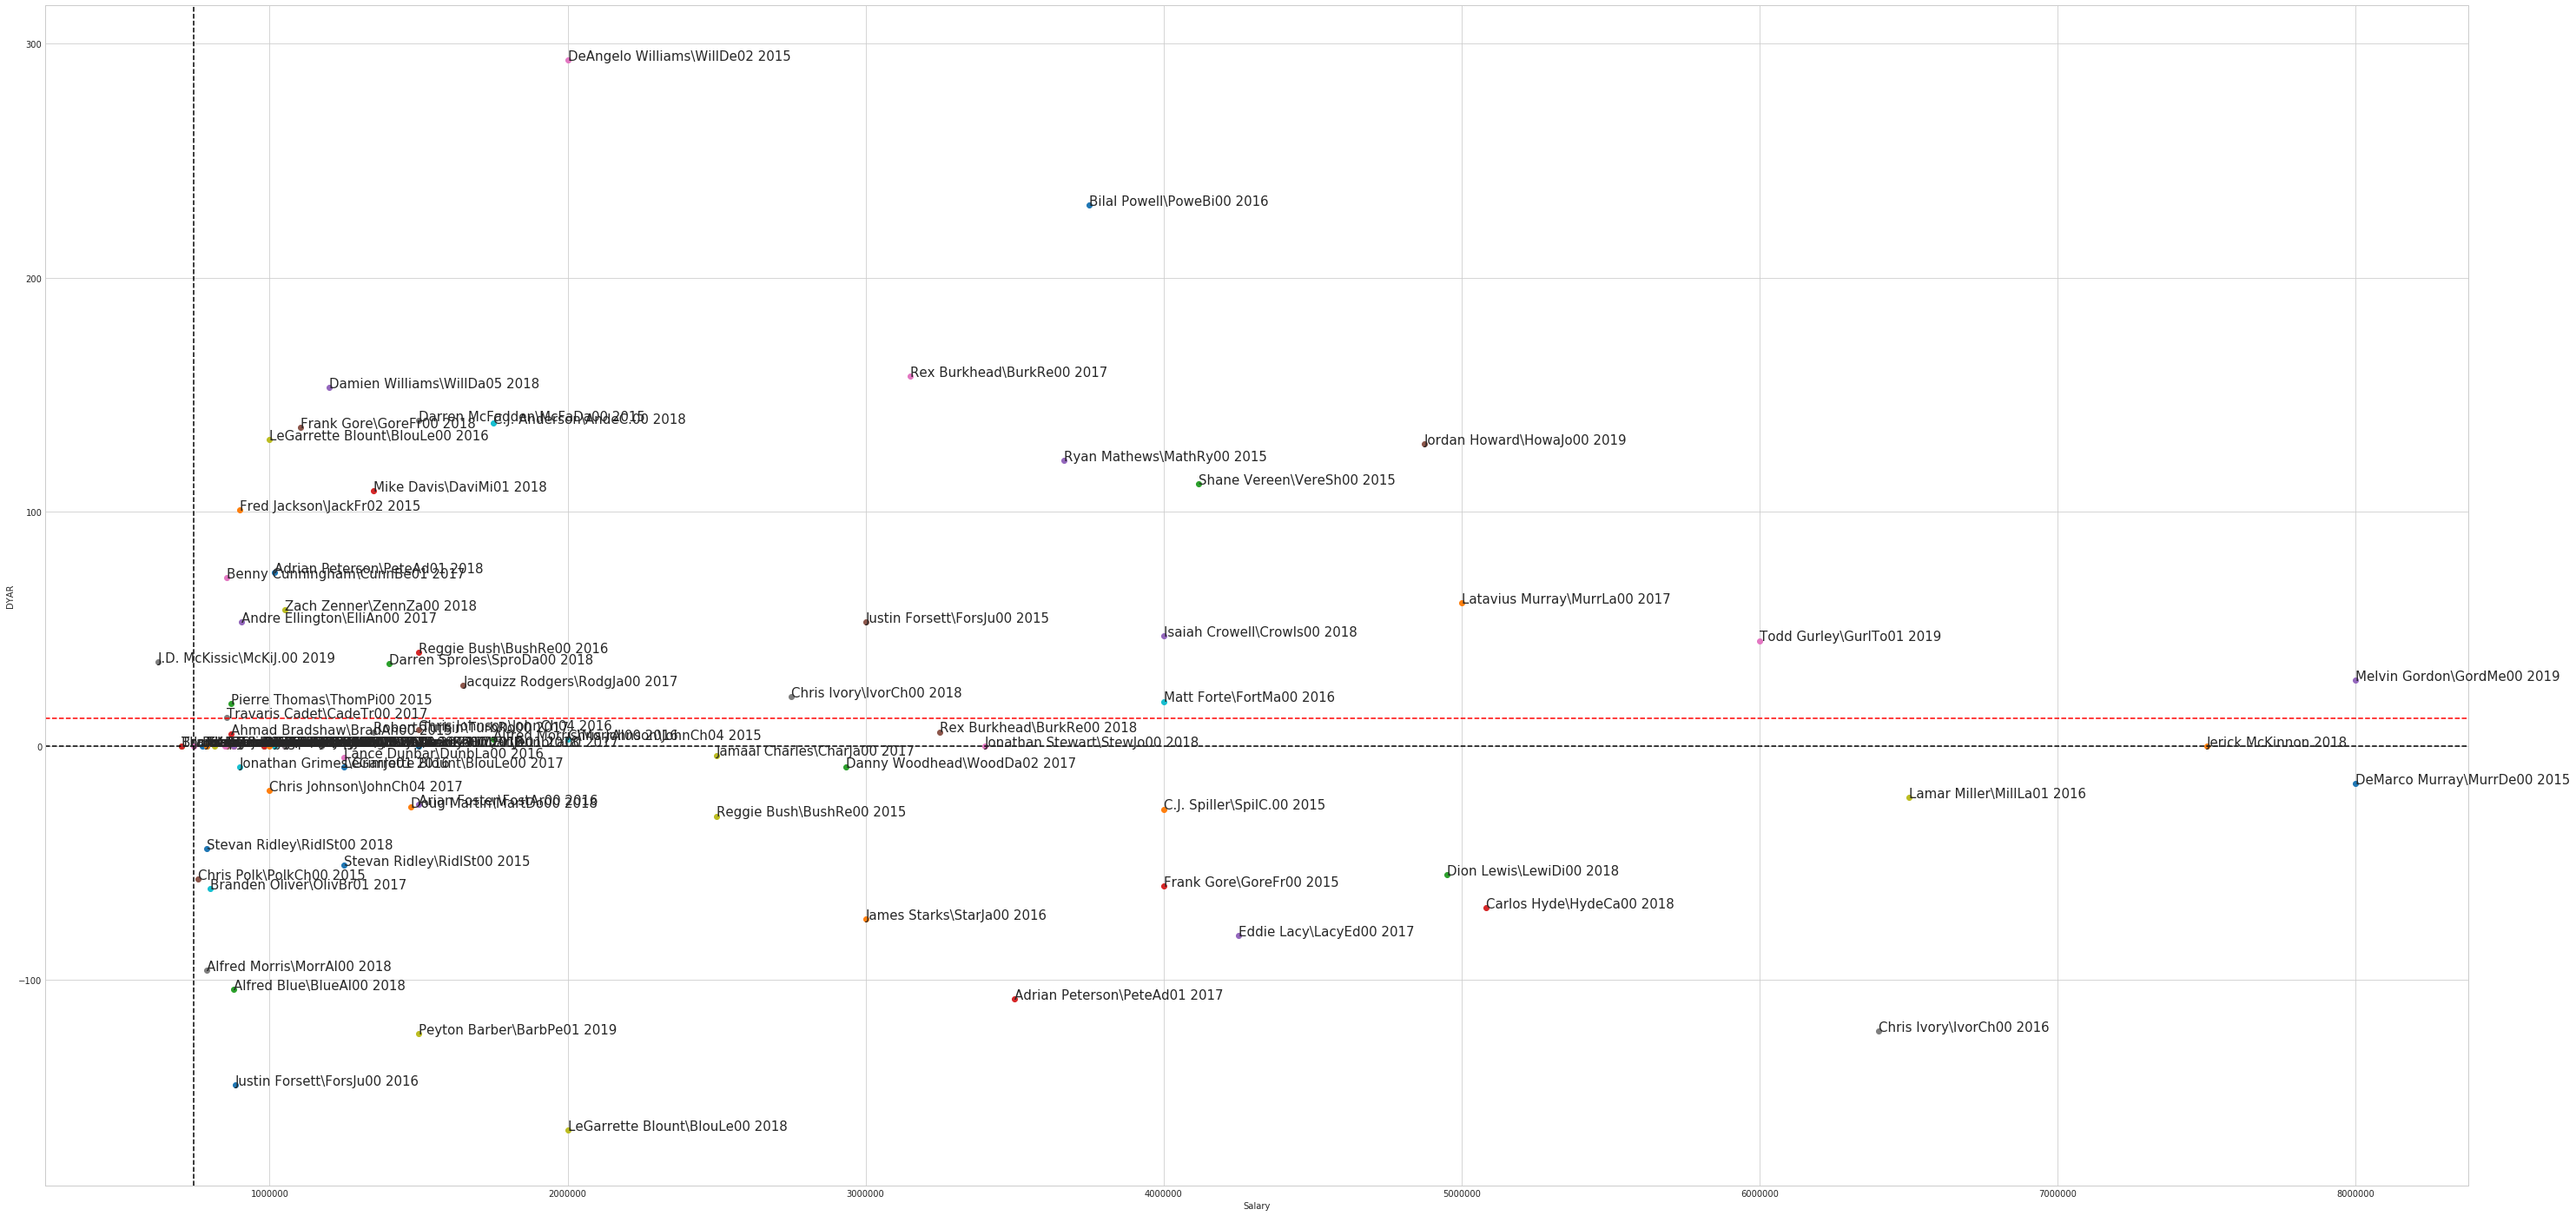

In [25]:
# USE GGPLOT FOR THIS 
# Put year next to the names of the players
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(50, 25))

allFARB = pd.concat([FA_Rush_2015,FA_Rush_2016,FA_Rush_2017,FA_Rush_2018,FA_Rush_2019 ]) 

x = pd.concat([FA_Rush_2015['AAV'],FA_Rush_2016['AAV'],FA_Rush_2017['AAV'],FA_Rush_2018['AAV'],FA_Rush_2019['AAV'] ]) 
y = pd.concat([FA_Rush_2015['DYAR'],FA_Rush_2016['DYAR'],FA_Rush_2017['DYAR'],FA_Rush_2018['DYAR'],FA_Rush_2019['DYAR'] ]) 
ppm = pd.concat([FA_Rush_2015['PPM'],FA_Rush_2016['PPM'],FA_Rush_2017['PPM'],FA_Rush_2018['PPM'],FA_Rush_2019['PPM'] ])

players = pd.concat([FA_Rush_2015['label'],FA_Rush_2016['label'],FA_Rush_2017['label'],FA_Rush_2018['label'],FA_Rush_2019['label'] ]) 

lowest_sal_15 = min(FA_Rush_2015['AAV'])
lowest_sal_16 = min(FA_Rush_2016['AAV'])
lowest_sal_17 = min(FA_Rush_2017['AAV'])
lowest_sal_18 = min(FA_Rush_2018['AAV'])
lowest_sal_19 = min(FA_Rush_2019['AAV'])

dyar_avg = statistics.mean(y)



plt.xlabel('Salary')
plt.ylabel('DYAR')

for x,y,z in zip(x, y, players):

    plt.scatter(x,y,label=z)
    plt.annotate(z, (x,y), fontsize= 15)
    
plt.axvline(x=lowest_sal_15, color='k', linestyle='--')
#plt.axvline(x=lowest_sal_16, color='g', linestyle='--')
#plt.axvline(x=lowest_sal_17, color='b', linestyle='--')
#plt.axvline(x=lowest_sal_18, color='cyan', linestyle='--')
plt.axhline(y = 0, color='k', linestyle='--')
plt.axhline(y = dyar_avg, color='r', linestyle='--')
    
#plt.savefig('FA_RB.png')





11.96629213483146
<generator object <genexpr> at 0x1c1cf77830>
None
r
b
g
lime


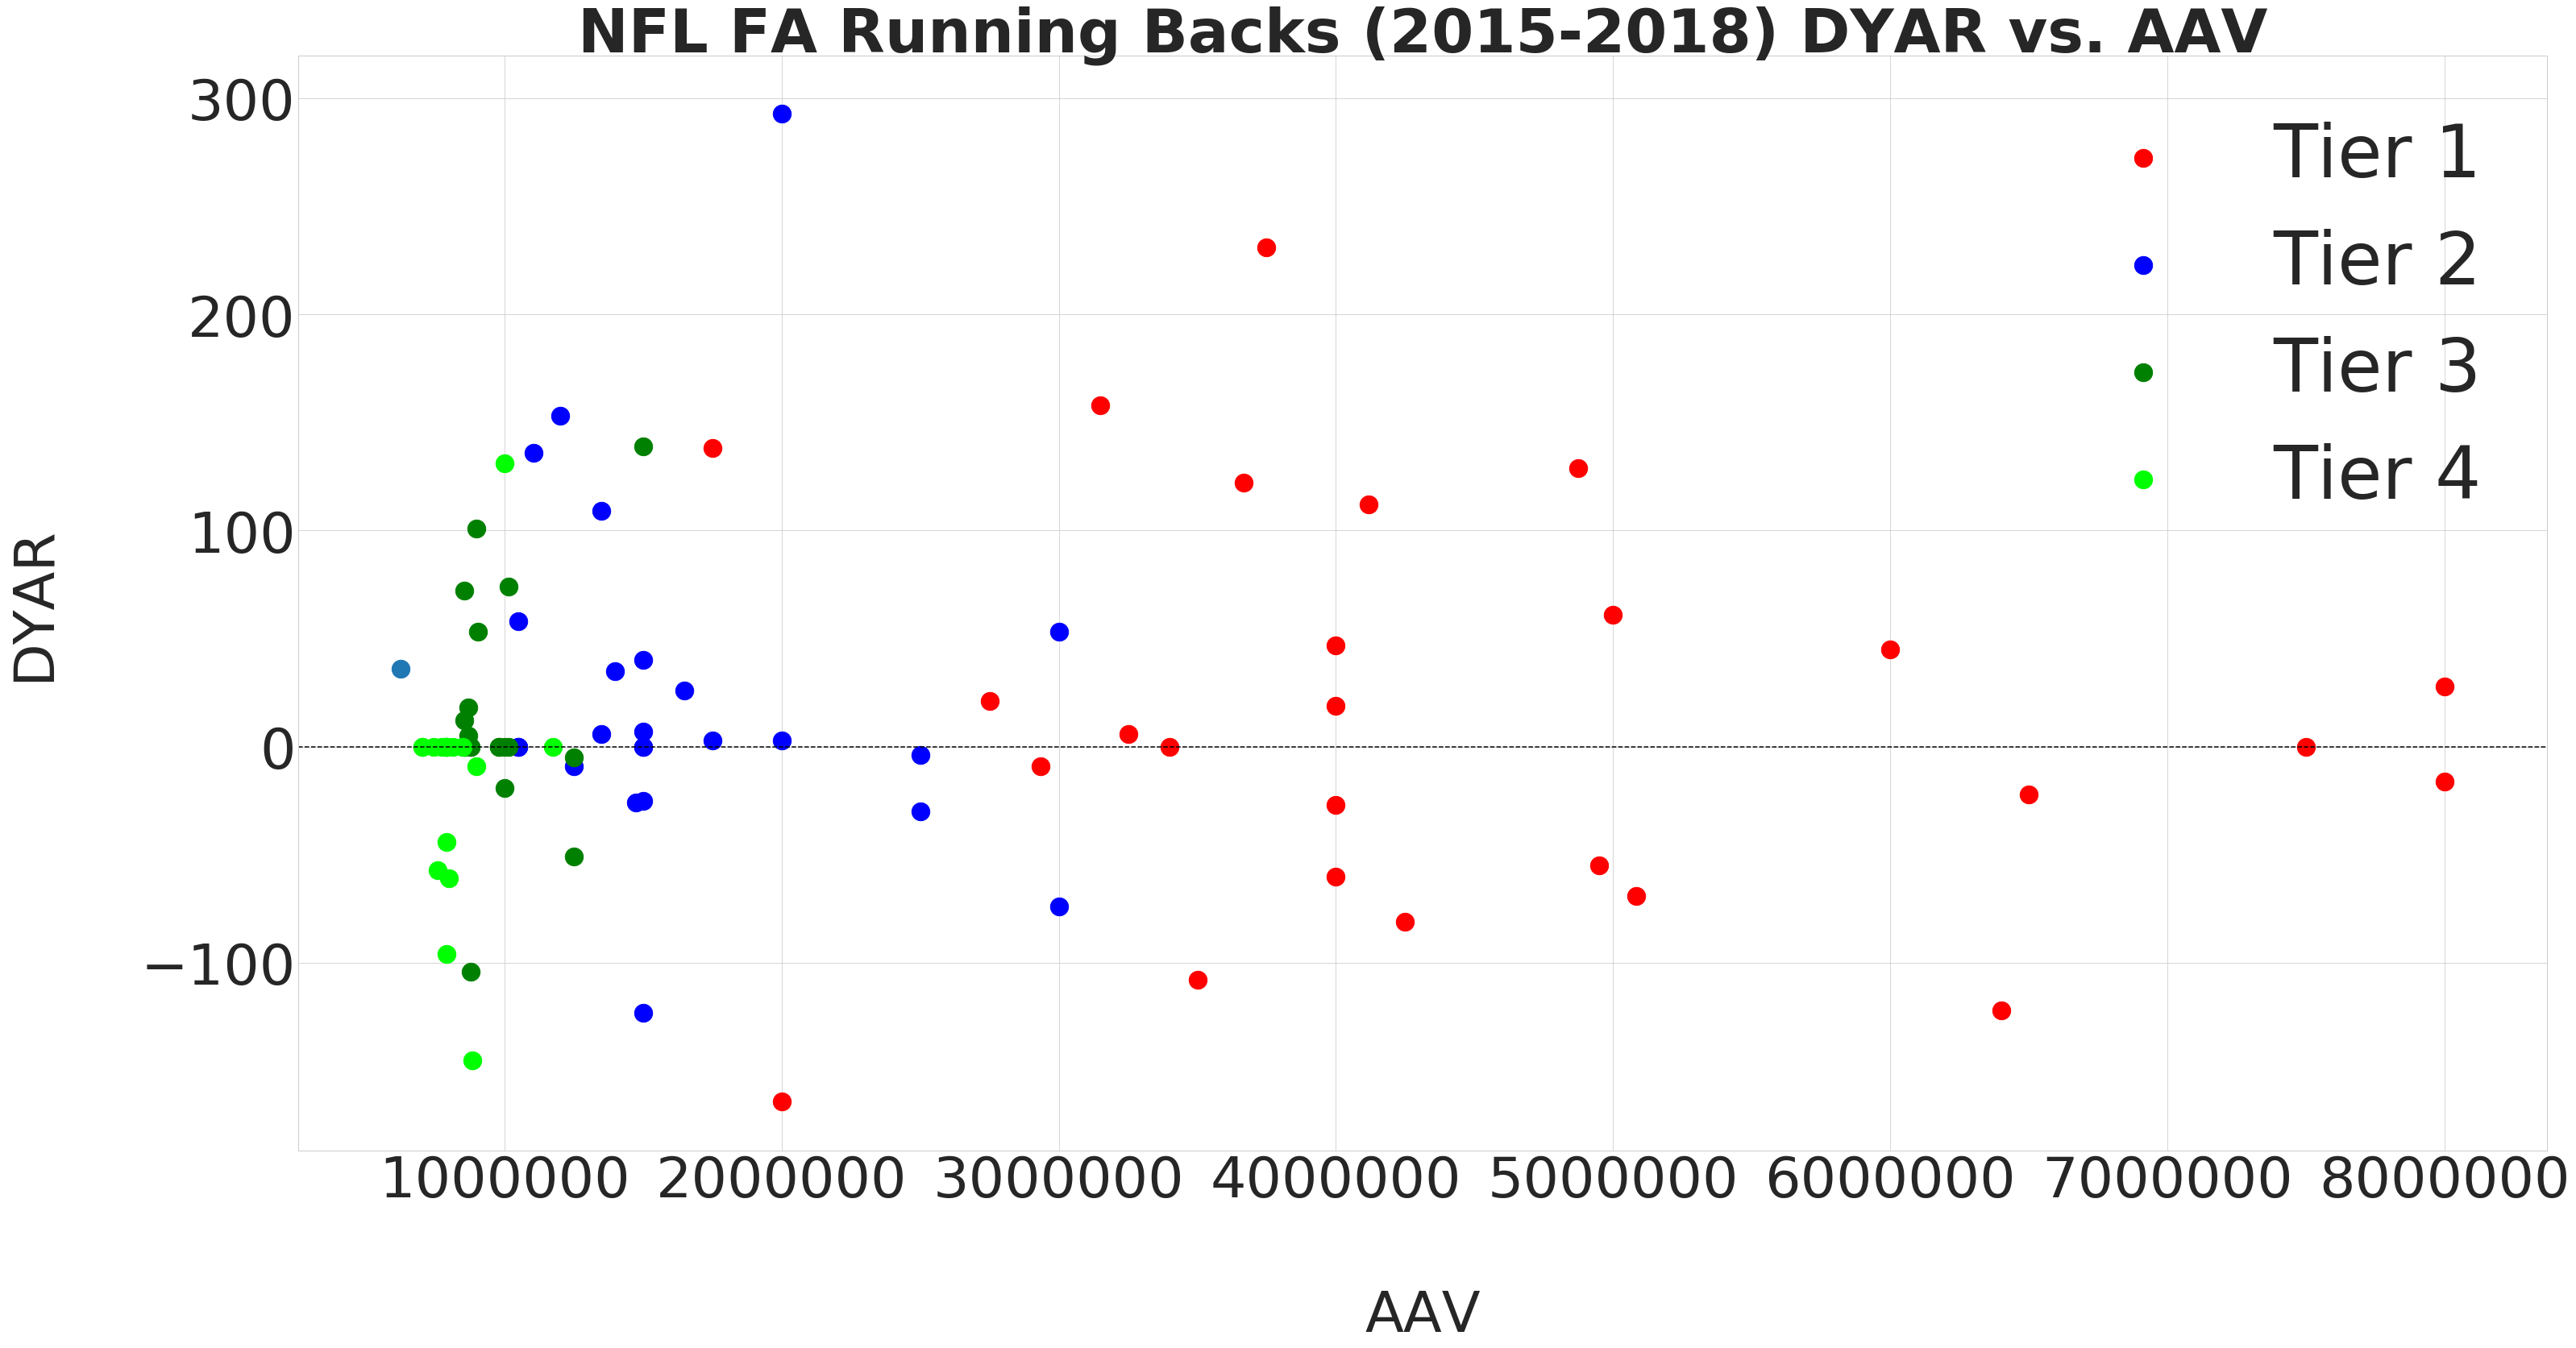

In [26]:
fig = plt.figure(figsize=(50, 25))


x = pd.concat([FA_Rush_2015['AAV'],FA_Rush_2016['AAV'],FA_Rush_2017['AAV'],FA_Rush_2018['AAV'],FA_Rush_2019['AAV'] ]) 
y = pd.concat([FA_Rush_2015['DYAR'],FA_Rush_2016['DYAR'],FA_Rush_2017['DYAR'],FA_Rush_2018['DYAR'],FA_Rush_2019['DYAR'] ]) 

Avg_DYAR = statistics.mean(y)
print(Avg_DYAR)

players = pd.concat([FA_Rush_2015['label'],FA_Rush_2016['label'],FA_Rush_2017['label'],
                     FA_Rush_2018['label'],FA_Rush_2019['label'] ]) 
term = pd.concat([FA_Rush_2015['Tier'],FA_Rush_2016['Tier'],FA_Rush_2017['Tier'],
                  FA_Rush_2018['Tier'],FA_Rush_2019['Tier'] ])

xs = np.array(x)
ys = np.array(y)
labels = np.array(term)



labels_masks =( (x,(labels == x)) for x in set(labels))
data_dict = dict( (lbl,(xs[mask],ys[mask])) for lbl,mask in labels_masks )

print(labels_masks)

label_dict = {1: 'r', 2: 'b', 3: 'g', 4: 'lime'}
legend_dict = {1: 'Tier 1', 2: 'Tier 2', 3: 'Tier 3', 4: 'Tier 4'}

for label,data in data_dict.items():
    x,y = data
    print(label_dict.get(label))
    plt.scatter(x,y,c=label_dict.get(label),label=legend_dict.get(label), s = 500)

plt.legend(prop={'size': 90})
plt.title('NFL FA Running Backs (2015-2018) DYAR vs. AAV', fontsize = 75,fontweight='bold')
plt.xlabel('AAV', fontsize=70, labelpad=100)
plt.ylabel('DYAR', fontsize=70, labelpad=100)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)



#plt.axvline(x=lowest_sal_16, color='g', linestyle='--')
plt.axhline(y = 0, color='k', linestyle='--')

plt.savefig('Rookie_RB.png')

plt.show()

# Rookie RB Value / AAV($)

/Users/RobertGreenberg/miniconda3/envs/comp135_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


0.0   -199.750826
0.1    -26.896583
0.2     -3.798666
0.3      0.000000
0.4      0.000000
0.5      0.000000
0.6     23.601847
0.7     39.981623
0.8     62.419139
0.9    127.597248
1.0    552.650597
Name: PPM, dtype: float64


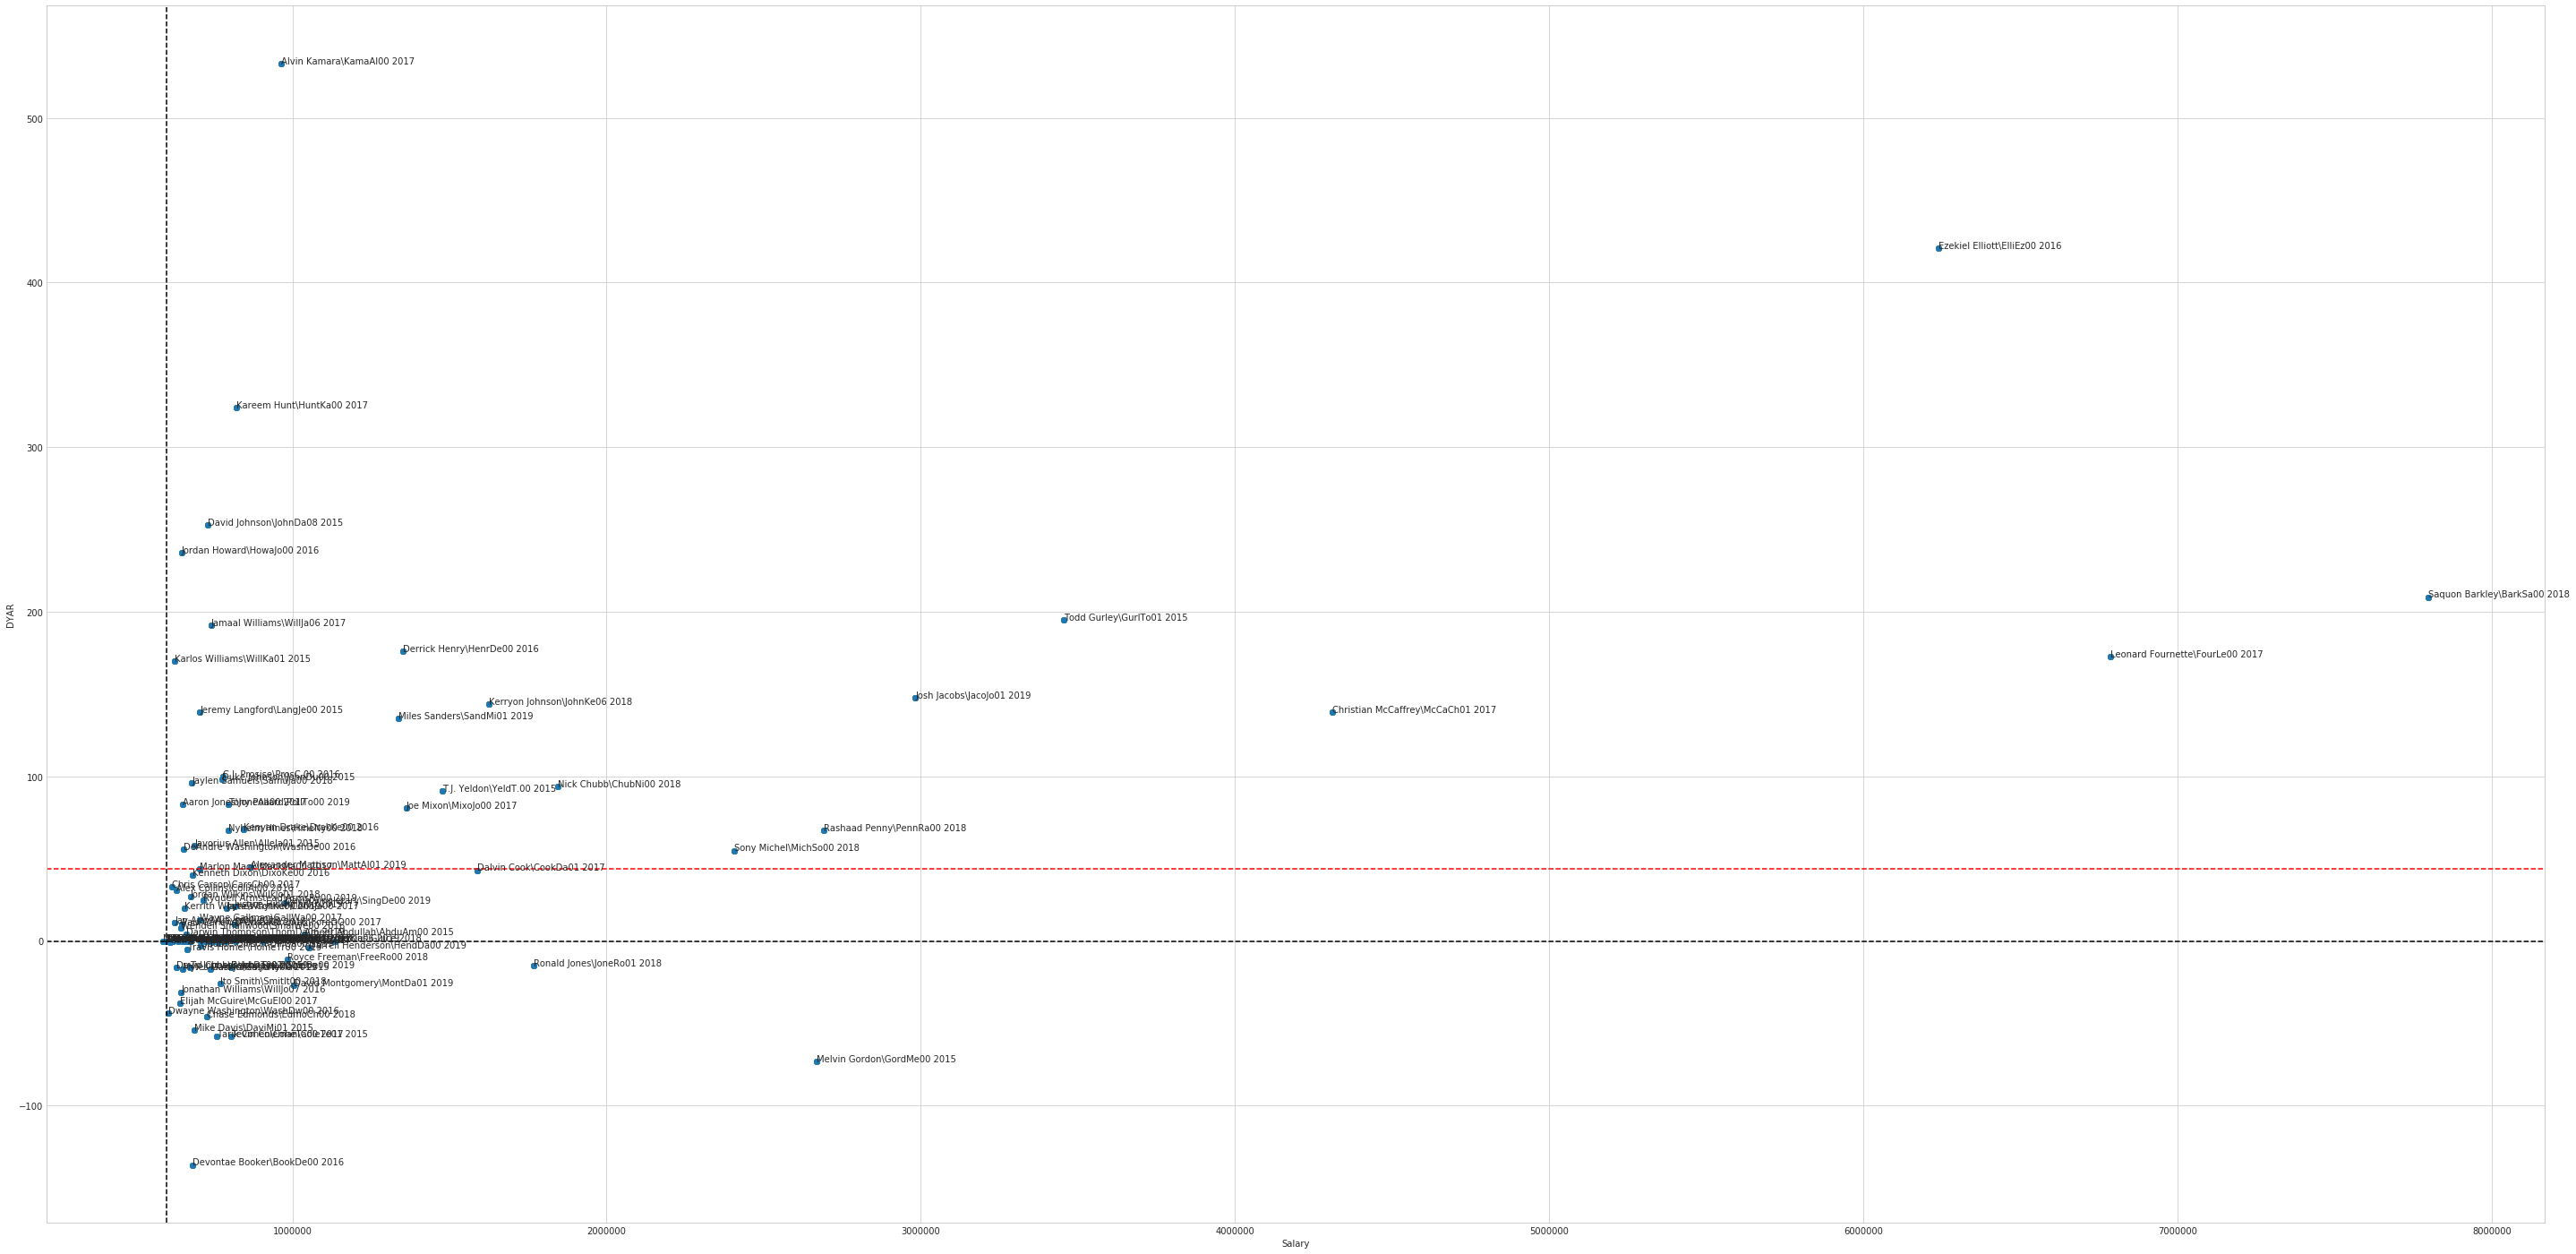

In [54]:
# USE GGPLOT FOR THIS 
# Put year next to the names of the players
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(50, 25))

allRookRB = pd.concat([Rookie_Rush_2015,Rookie_Rush_2016,Rookie_Rush_2017,Rookie_Rush_2018,Rookie_Rush_2019 ]) 

x = pd.concat([Rookie_Rush_2015['AAV'],Rookie_Rush_2016['AAV'],Rookie_Rush_2017['AAV'],Rookie_Rush_2018['AAV'],Rookie_Rush_2019['AAV'] ]) 
y = pd.concat([Rookie_Rush_2015['DYAR'],Rookie_Rush_2016['DYAR'],Rookie_Rush_2017['DYAR'],Rookie_Rush_2018['DYAR'],Rookie_Rush_2019['DYAR'] ]) 
ppm = pd.concat([Rookie_Rush_2015['PPM'],Rookie_Rush_2016['PPM'],Rookie_Rush_2017['PPM'],Rookie_Rush_2018['PPM'],Rookie_Rush_2019['PPM'] ])

players = pd.concat([Rookie_Rush_2015['label'],Rookie_Rush_2016['label'],Rookie_Rush_2017['label'],Rookie_Rush_2018['label'],Rookie_Rush_2019['label'] ])
round_picked = pd.concat([Rookie_Rush_2015['ROUND'],Rookie_Rush_2016['ROUND'],Rookie_Rush_2017['ROUND'],Rookie_Rush_2018['ROUND'],Rookie_Rush_2019['ROUND'] ])


b, m = np.polyfit(x, y, 1)


lowest_sal_15 = min(Rookie_Rush_2015['AAV'])
lowest_sal_16 = min(Rookie_Rush_2016['AAV'])
lowest_sal_17 = min(Rookie_Rush_2017['AAV'])
lowest_sal_18 = min(Rookie_Rush_2018['AAV'])
lowest_sal_19 = min(Rookie_Rush_2019['AAV'])

print(ppm.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

dyar_avg = statistics.mean(y)



plt.xlabel('Salary')
plt.ylabel('DYAR')

for a,b,c in zip(x, y, players):
    plt.scatter(x,y,label=c)
    plt.annotate(c, xy = (int(a),int(b)))
    
    
#plt.axvline(x=lowest_sal_15, color='r', linestyle='--')
plt.axvline(x=lowest_sal_16, color='k', linestyle='--')
#plt.axvline(x=lowest_sal_17, color='b', linestyle='--')
#plt.axvline(x=lowest_sal_18, color='cyan', linestyle='--')
plt.axhline(y = 0, color='k', linestyle='--')
plt.axhline(y = dyar_avg, color='r', linestyle='--')
#
#plt.savefig('Rookie_RB.png')
plt.show()





43.584158415841586
<generator object <genexpr> at 0x1c1b672518>


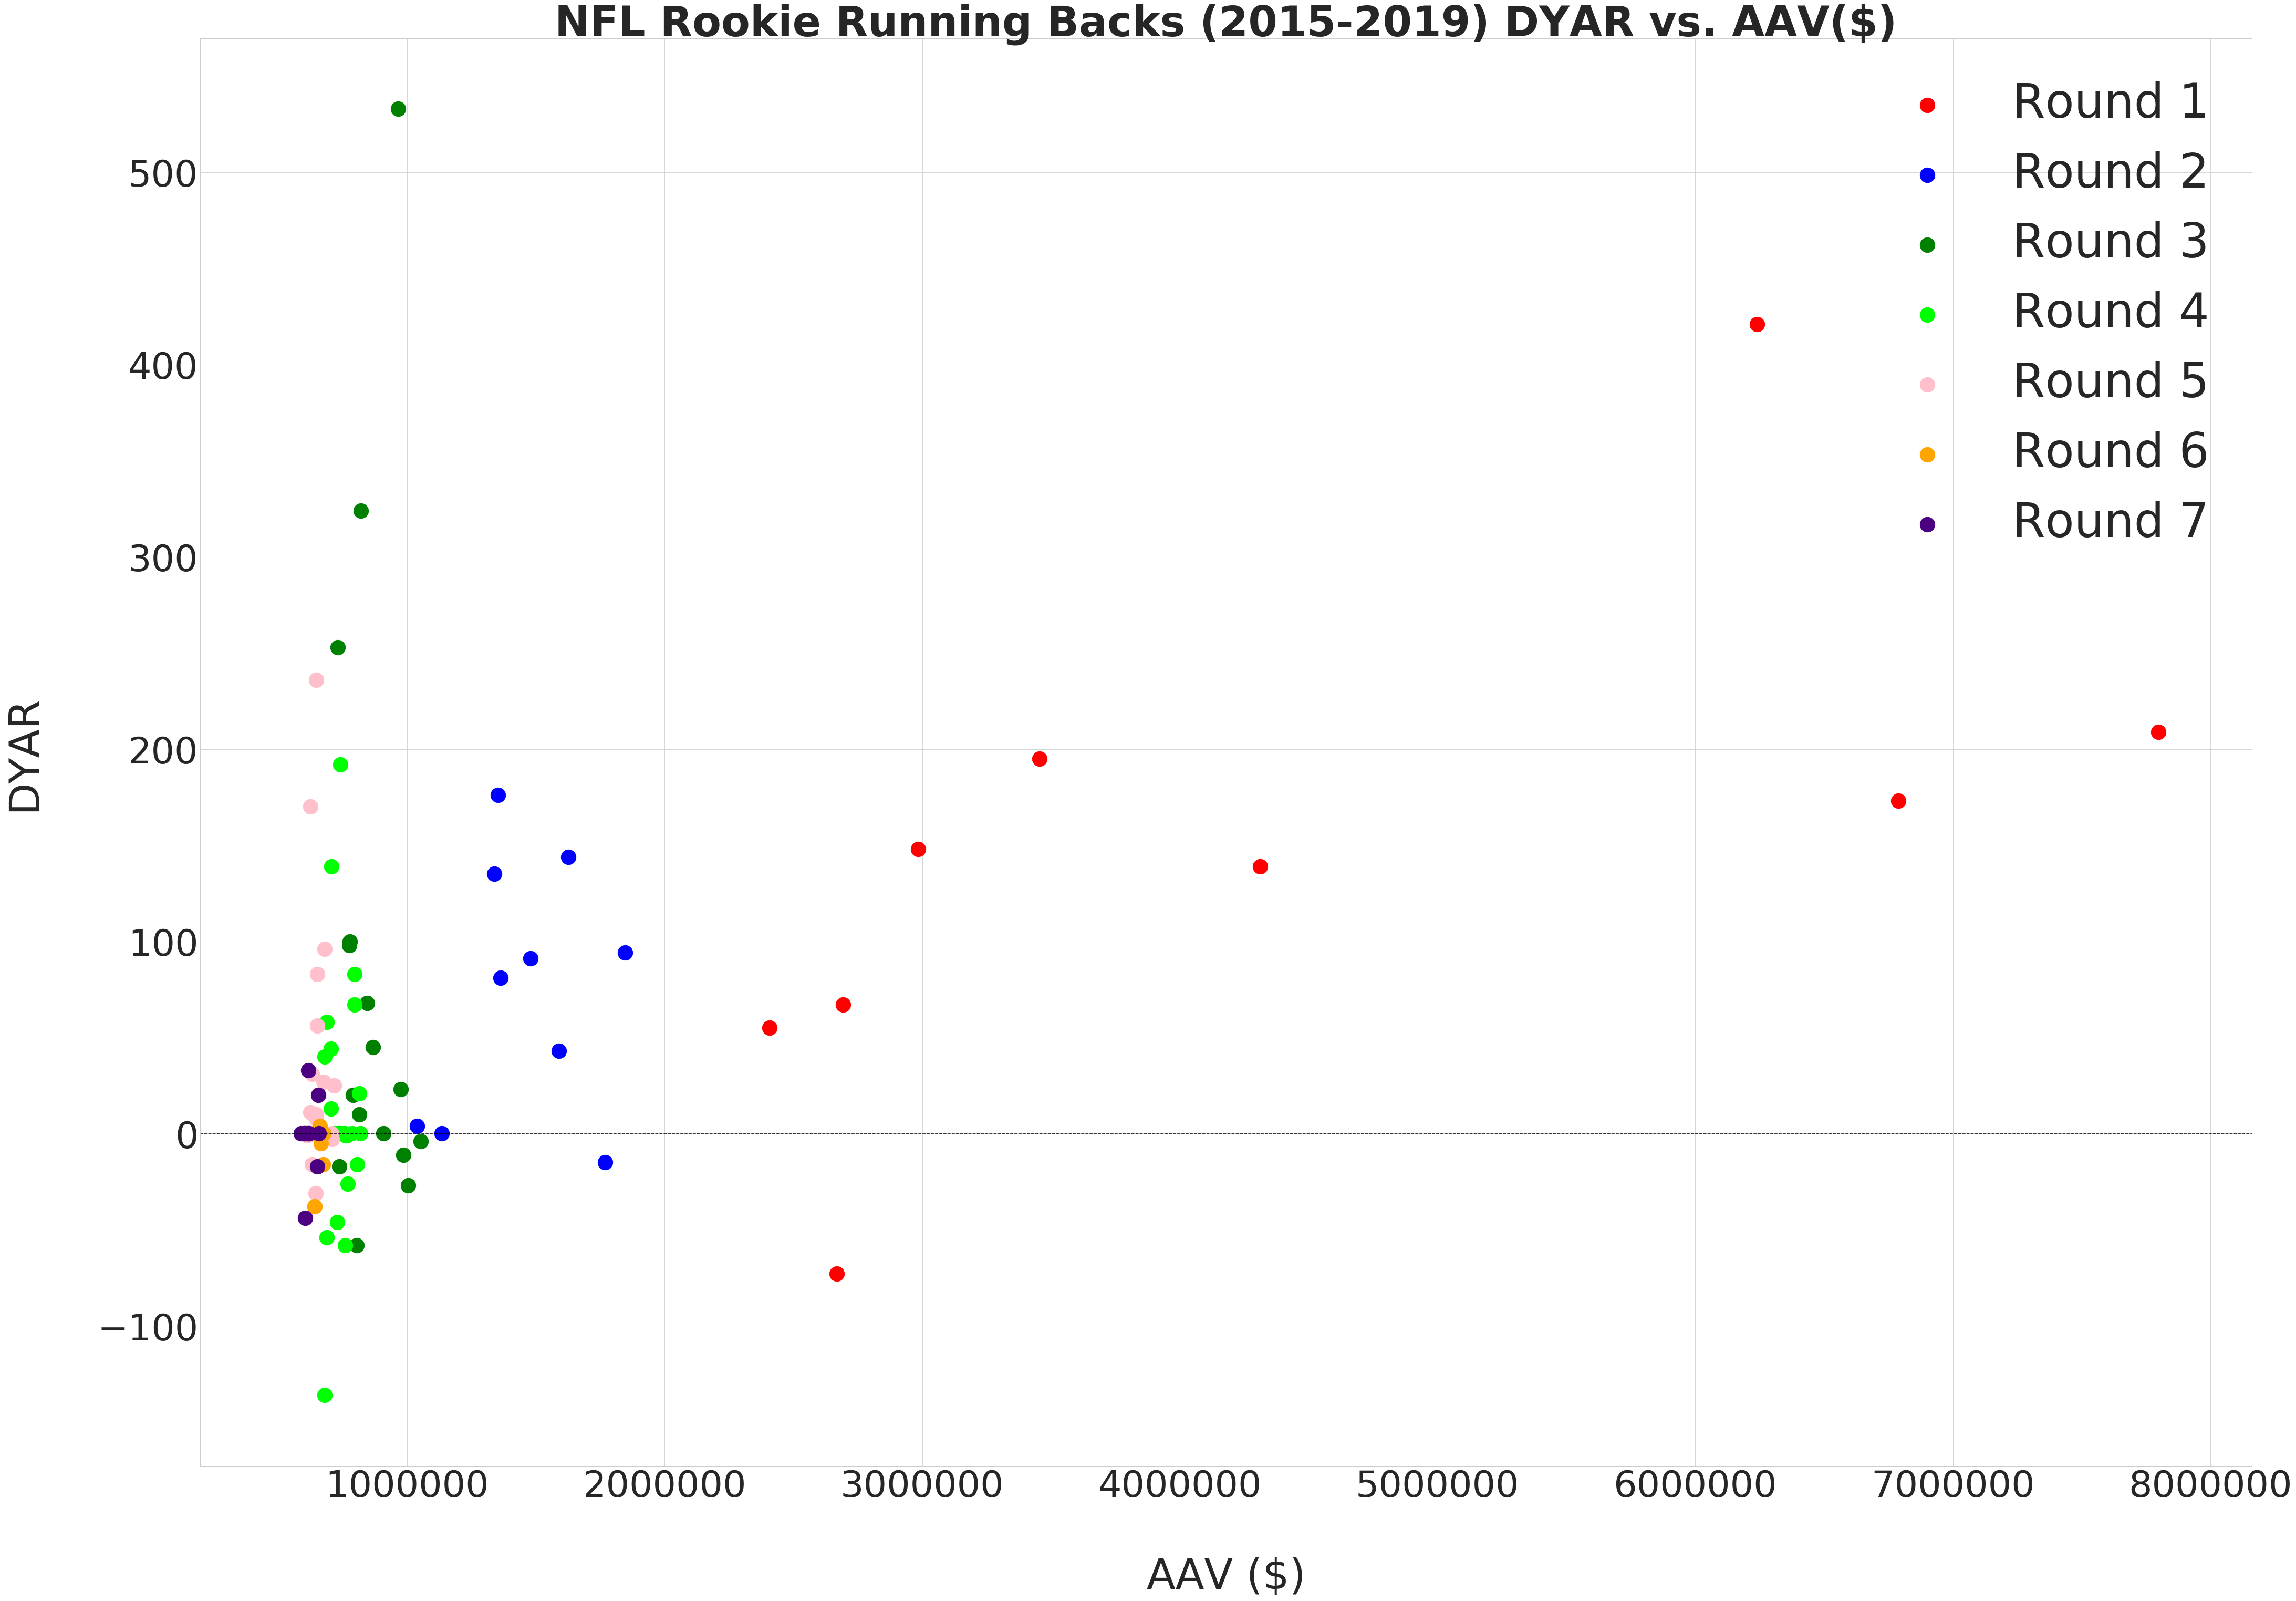

In [55]:
fig = plt.figure(figsize=(70, 50))

xs = np.array(x)
ys = np.array(y)
labels = np.array(round_picked)

Avg_DYAR = statistics.mean(y)
print(Avg_DYAR)


labels_masks =( (x,(labels == x)) for x in set(labels))
data_dict = dict( (lbl,(xs[mask],ys[mask])) for lbl,mask in labels_masks )

print(labels_masks)

label_dict = {1: 'r', 2: 'b', 3: 'g', 4: 'lime', 5:'pink', 6:'orange', 7:'indigo'}
legend_dict = {1: 'Round 1', 2: 'Round 2', 3: 'Round 3', 4: 'Round 4', 5:'Round 5', 6:'Round 6', 7:'Round 7'}

for label,data in data_dict.items():
    x,y = data
    plt.scatter(x,y,c=label_dict.get(label),label=legend_dict.get(label), s = 800)

plt.legend(prop={'size': 90})
plt.title('NFL Rookie Running Backs (2015-2019) DYAR vs. AAV($)', fontsize = 80,fontweight='bold')
plt.xlabel('AAV ($)', fontsize=80, labelpad=100)
plt.ylabel('DYAR', fontsize=80, labelpad=100)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)

#plt.axvline(x=lowest_sal_16, color='k', linestyle='--')
plt.axhline(y = 0, color='k', linestyle='--')


plt.savefig('Rookie_RB.png')

plt.show()

## Looking at FA Contract Breakdowns 

#### Total Guarenteed Money vs. DYAR

####  yearly cap vs. DYAR

### year breakdown DYAR vs. AAV 

### year breakdown DYAR vs. per year cap hit 

## Looking at Rookie RB Contract Breakdowns 

### Yearly DYAR performance vs. AAV 

### Yearly DYAR performance vs. signing bonus

In [56]:
print(FA_Rush_2015)

                        Player POS.  AGE FROM   TO  YRS   DOLLARS      AAV  \
0      DeMarco Murray\MurrDe00   RB   27  DAL  PHI    5  40000000  8000000   
1        C.J. Spiller\SpilC.00   RB   28  BUF   NO    4  16000000  4000000   
2        Shane Vereen\VereSh00   RB   26   NE  NYG    3  12350000  4116667   
3          Frank Gore\GoreFr00   RB   32   SF  IND    3  12000000  4000000   
4        Ryan Mathews\MathRy00   RB   27   SD  PHI    3  11000000  3666667   
5      Justin Forsett\ForsJu00   RB   29  BAL  BAL    3   9000000  3000000   
6   DeAngelo Williams\WillDe02   RB   32  CAR  PIT    2   4000000  2000000   
7     Darren McFadden\McFaDa00   RB   28  OAK  DAL    2   3000000  1500000   
8         Reggie Bush\BushRe00   RB   30  DET   SF    1   2500000  2500000   
9       Chris Johnson\JohnCh04   RB   29  NYJ  ARI    1   2000000  2000000   
10      Stevan Ridley\RidlSt00   RB   26   NE  NYJ    1   1250000  1250000   
11       Fred Jackson\JackFr02   RB   34  BUF  SEA    1    90000

### year breakdown DYAR vs. per year cap hit 

# The Model

idea is to have a model that based on a player's DYAR performance cluster, we can determine an approximate salary that they should be paid, by getting the median salary for players with similar performance (mean could throw it off). Then we can take it a step further and look at draft payouts.

In [57]:
#Decision tree trained on all RB's from 2015-2018 on Rookie and FA data, given DYAR what should salries be

In [58]:
RB_Salary_2015 = pd.read_csv('RB_2015_Sal.csv')
RB_Salary_2015['Player'] = RB_Salary_2015['Player'].str.replace(r'[*,+]', '')

RB_Salary_2016 = pd.read_csv('RB_2016_Sal.csv')
RB_Salary_2016['Player'] = RB_Salary_2016['Player'].str.replace(r'[*,+]', '')

RB_Salary_2017 = pd.read_csv('RB_2017_Sal.csv')
RB_Salary_2017['Player'] = RB_Salary_2017['Player'].str.replace(r'[*,+]', '')

RB_Salary_2018 = pd.read_csv('RB_2018_Sal.csv')
RB_Salary_2018['Player'] = RB_Salary_2018['Player'].str.replace(r'[*,+]', '')

RB_Salary_2019 = pd.read_csv('RB_2019_Sal.csv')
RB_Salary_2019['Player'] = RB_Salary_2019['Player'].str.replace(r'[*,+]', '')


RB_2015 = RUSH_FO_2015.merge(REC_FO_2015, how='left',on='Player')
RB_2015 = RB_2015.merge(RB_Salary_2015, how='left',on='Player')

RB_2016 = RUSH_FO_2016.merge(REC_FO_2016, how='left',on='Player')
RB_2016 = RB_2016.merge(RB_Salary_2016, how='left',on='Player')

RB_2017 = RUSH_FO_2017.merge(REC_FO_2017, how='left',on='Player')
RB_2017 = RB_2017.merge(RB_Salary_2017, how='left',on='Player')

RB_2018 = RUSH_FO_2018.merge(REC_FO_2018, how='left',on='Player')
RB_2018 = RB_2018.merge(RB_Salary_2018, how='left',on='Player')

RB_2019 = RUSH_FO_2019.merge(REC_FO_2019, how='left',on='Player')
RB_2019 = RB_2019.merge(RB_Salary_2019, how='left',on='Player')

#print(RB_2018)

RB_big_board = pd.concat([RB_2019,RB_2018,RB_2017,RB_2016,RB_2015])

RB_big_board = RB_big_board.fillna(value = 0.)
RB_big_board['DYAR'] = RB_big_board['DYAR_x'] + RB_big_board['DYAR_y']

#RB_big_board['DVOA'] = RB_big_board['DVOA_x'] + RB_big_board['DVOA_y'] # may have to go back in and convert DVOA to numeric

#print(RB_big_board.info())


# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
#indexNames = Rush_2018[Rush_2018['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
RB_big_board = RB_big_board.dropna(subset=['DYAR'])
#RB_big_board = RB_big_board.loc[:, ~FA_Rush_2018.columns.str.contains('^Unnamed')]
RB_big_board.sort_values(by=['DYAR'], ascending=False)
#print(FA_Rush_2018)

RB_big_board['PPM'] = 1000000*(RB_big_board['DYAR']/RB_big_board['Salary Cap Value'])
RB_big_board=RB_big_board.replace([np.inf, -np.inf], np.nan)
RB_big_board['PPM'].dropna(how='all')
RB_big_board = RB_big_board[RB_big_board['Salary Cap Value'] != 0.0]
#RB_big_board['TDs'].dropna(how='all')

print("PPM Quantiles: " ,RB_big_board['PPM'].quantile([0, 0.25, 0.5, 0.75, 1.]))
print("DYAR Quantiles: ",RB_big_board['DYAR'].quantile([0, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8,0.9, 1.]))
print("Salary Cap Hit Quantiles: ",RB_big_board['Salary Cap Value'].quantile([0, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8,0.9,0.95,0.99, 1.]))


#print(np.isnan(RB_big_board['PPM'])

PPM Quantiles:  0.00    -696.328667
0.25      -5.073173
0.50      30.727273
0.75     109.878586
1.00    1484.812946
Name: PPM, dtype: float64
DYAR Quantiles:  0.00   -164.0
0.25     -9.0
0.50     34.0
0.60     59.0
0.70     92.0
0.75    113.0
0.80    141.4
0.90    200.0
1.00    658.0
Name: DYAR, dtype: float64
Salary Cap Hit Quantiles:  0.00       68824.0
0.25      585000.0
0.50      767664.0
0.60     1084261.6
0.70     1736728.0
0.75     2075000.0
0.80     2737167.6
0.90     4870833.6
0.95     6451895.9
0.99     9618000.0
1.00    15400000.0
Name: Salary Cap Value, dtype: float64


/Users/RobertGreenberg/miniconda3/envs/comp135_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



0.10    -52.0
0.20    -18.0
0.25     -9.0
0.30      0.0
0.40      5.0
0.50     20.0
0.60     47.0
0.70     81.0
0.75     98.0
0.80    127.0
0.90    191.0
1.00    533.0
Name: DYAR, dtype: float64
0.10      496096.00
0.20      597041.50
0.25      615000.00
0.30      631096.25
0.40      713289.00
0.50      836023.00
0.60     1050000.00
0.70     1572775.00
0.75     1957352.00
0.80     2516666.00
0.90     4418106.00
1.00    15400000.00
Name: AAV, dtype: float64

In [69]:
print(np.nanmean(RB_big_board['PPM']))
print(statistics.median(RB_big_board['PPM']))

print(RB_big_board['Salary Cap Value'])
RB_big_board['AAV'] = RB_big_board['Salary Cap Value']


#& (RB_big_board['Salary Cap Value'] <= 2000000.0)


conditions = [
    (RB_big_board['Salary Cap Value'] <= 1957352.00)  & (RB_big_board['DYAR'] >= 98.0), #make 75th percentile or less, 75th in DYAR, 
    (RB_big_board['Salary Cap Value'] >= 615000.00) & (RB_big_board['Salary Cap Value'] <=  2516666.00) & (RB_big_board['DYAR'] >= -9.0) & (RB_big_board['DYAR'] <= 98.0), #between 25 and 75 in most 
    (RB_big_board['Salary Cap Value'] >=  836023.00) & (RB_big_board['Salary Cap Value'] <= 15400000.0) & (RB_big_board['DYAR'] <= -9.0) & (RB_big_board['DYAR'] >= -167.0),
    ]


conditions_1 = [
    (RB_big_board['Salary Cap Value'] <= 2000000.0)  & (RB_big_board['DYAR'] >= 112.), #make 75th percentile or less, 75th in DYAR, above 50th in PPM
    (RB_big_board['Salary Cap Value'] >= 570409.0) & (RB_big_board['Salary Cap Value'] <=  8000000.0) & (RB_big_board['DYAR'] >= 0) & (RB_big_board['DYAR'] <= 112.), #between 25 and 75 in most 
    (RB_big_board['Salary Cap Value'] >=  753750.0) & (RB_big_board['Salary Cap Value'] <= 15400000.0) & (RB_big_board['DYAR'] <= 112.) & (RB_big_board['DYAR'] >= -167.0),
    ]






# MAY NEED TO REBUCKET THESE SO THEY COVER EVERYTHING


choices = ['good value', 'fair value', 'poor value']

RB_big_board['class'] = np.select(conditions_2, choices, default='fair value')

# a good deal is determined if performance/AAV is greater than 0, if you have a negative PPM, it means you are worse than replacement level and getting paid more than the minimum, which is more than you deserve based on performance
#RB_big_board['class'] = np.where(RB_big_board['PPM'] >= 50, 'good deal', 'bad deal')
#RB_big_board['class'] = np.where((RB_big_board['Salary Cap Value'] <= 2500000) & (RB_big_board['DYAR'] >= 0) & (RB_big_board['PPM'] >= 1) , 'good deal', 'bad deal')



count = 0
for i in RB_big_board['class']:
      if i == 'good value':
        count = count + 1
        
good_deal_pct = count/len(RB_big_board) *100
print(str(good_deal_pct) + '%')

print()

66.83870173352256
30.72727272727273
0      6339653.0
1      4702174.0
2      3333333.0
3       695487.0
4      1072059.0
5      1720705.0
6      1895833.0
7      1732721.0
8      1677976.0
9       661285.0
10     2169709.0
11     1850000.0
12      570000.0
13     2025000.0
14      749912.0
15      575000.0
16     1486408.0
17     7089716.0
18     1050693.0
19      753956.0
20     1900000.0
21     9200000.0
22     1607256.0
23     1780000.0
24      786498.0
25      646668.0
26      700545.0
27     3000000.0
28     2187885.0
29      974587.0
         ...    
73     2516666.0
74       90000.0
75      476563.0
76      800000.0
77      435333.0
79      588334.0
80     3350000.0
81      621311.0
82      609272.0
83      497136.0
84     3500000.0
85      441088.0
86      435144.0
87      585000.0
88      585000.0
89     1266666.0
90      232941.0
91      150000.0
92      736504.0
94      333412.0
95      607750.0
96     2000000.0
97      753750.0
98      343235.0
99     1035000.0
101    30000

NameError: name 'conditions_2' is not defined

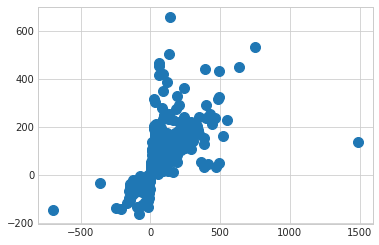

In [33]:
plt.scatter(RB_big_board['PPM'], RB_big_board['DYAR'], s=100, cmap='viridis')

## Rookie deal tester

In [51]:
rookie_sal = pd.concat([Rookie_Rush_2015['AAV'],Rookie_Rush_2016['AAV'],Rookie_Rush_2017['AAV'],Rookie_Rush_2018['AAV'] ]) 
rookie_dyar = pd.concat([Rookie_Rush_2015['DYAR'],Rookie_Rush_2016['DYAR'],Rookie_Rush_2017['DYAR'],Rookie_Rush_2018['DYAR'] ]) 
rookie_ppm = pd.concat([Rookie_Rush_2015['PPM'],Rookie_Rush_2016['PPM'],Rookie_Rush_2017['PPM'],Rookie_Rush_2018['PPM'] ])


print(allRookRB['PPM'].quantile([0, 0.25, 0.5, 0.75, 1.]))
print(allRookRB['DYAR'].quantile([0, 0.25, 0.5, 0.75, 1.]))
print(allRookRB['AAV'].quantile([0, 0.25, 0.5, 0.75, 1.]))
# CHANGE THIS:
# MAke categories which are combinations of DYAR and AAV and PPM to realize a players worth


# great value could be... paid in the bottom 25th percentile, but DYAR is 75TH percentile 
# good value 
# average value
# below-average value
# poor value

# You should be paid less than the median salary, but playing better than the median dyar 


print(lowest_sal_15)

conditions = [
    (allRookRB['AAV'] <= 839343.875) & (allRookRB['DYAR'] >= 82.5), #75th or less in pay, 75th in DYAR, 50th in PPM
    (allRookRB['AAV'] >= 642901.875) & (allRookRB['AAV'] <= 839343.875) & (allRookRB['DYAR'] <= 82.5) & (allRookRB['DYAR'] >= 0.0) ,
    (allRookRB['AAV'] >= 724991.000) & (allRookRB['AAV'] <= 7798687.750) & (allRookRB['DYAR'] <= 6.0)
    ]
choices = ['good value', 'fair value', 'poor value']


# Class is PPS (Performance Per Salary)

allRookRB['class'] = np.select(conditions, choices, default='fair value')
allRookRB['class'] 

features = ['DYAR', 'AAV'] 
testset_Rook = allRookRB[features]


count = 0
for i in allRookRB['class']:
      if i == 'good value':
        count = count + 1
        
good_deal_pct = count/len(allRookRB) *100
print(str(good_deal_pct) + '%')




0.00   -199.750826
0.25      0.000000
0.50      0.000000
0.75     53.546893
1.00    552.650597
Name: PPM, dtype: float64
0.00   -136.0
0.25      0.0
0.50      0.0
0.75     67.0
1.00    533.0
Name: DYAR, dtype: float64
0.00     587322.25
0.25     650484.25
0.50     721892.25
0.75     867793.00
1.00    7798687.75
Name: AAV, dtype: float64
587322.25
10.891089108910892%


## FA Model Tester

In [52]:
FA_sal = pd.concat([FA_Rush_2015['AAV'],FA_Rush_2016['AAV'],FA_Rush_2017['AAV'],FA_Rush_2018['AAV'] ]) 
FA_dyar = pd.concat([FA_Rush_2015['DYAR'],FA_Rush_2016['DYAR'],FA_Rush_2017['DYAR'],FA_Rush_2018['DYAR'] ]) 
FA_ppm = pd.concat([FA_Rush_2015['PPM'],FA_Rush_2016['PPM'],FA_Rush_2017['PPM'],FA_Rush_2018['PPM'] ])
FA_gtd = pd.concat([FA_Rush_2015['%GTD'],FA_Rush_2016['%GTD'],FA_Rush_2017['%GTD'],FA_Rush_2018['%GTD'] ])

allFARB = allFARB[allFARB['AAV'] != 0]

print(allFARB['PPM'].quantile([0, 0.25, 0.5, 0.75, 1.]))
print(allFARB['DYAR'].quantile([0, 0.25, 0.5, 0.75, 1.]))
print(allFARB['AAV'].quantile([0, 0.25, 0.5, 0.75, 1.]))
print(allFARB['%GTD'].quantile([0, 0.25, 0.5, 0.75, 1.]))
# CHANGE THIS:
# MAke categories which are combinations of DYAR and AAV and PPM to realize a players worth


# great value could be... paid in the bottom 25th percentile, but DYAR is 75TH percentile 
# good value 
# average value
# below-average value
# poor value

# You should be paid less than the median salary, but playing better than the median dyar 

conditions = [
    (allFARB['AAV'] <= 1250000.00) & (allFARB['DYAR'] >= 28.25), #25th in pay, 75th in DYAR, 50th in PPM
    (allFARB['AAV'] >= 880000.00) & (allFARB['AAV'] <=  2949999.75) & (allFARB['DYAR'] <= 28.25) & (allFARB['DYAR'] >= 0.0) ,
    (allFARB['AAV'] >= 1250000.00) & (allFARB['AAV'] <= 7798687.750) & (allFARB['DYAR'] <= 0)
    ]
choices = ['good value', 'fair value', 'poor value']

allFARB['class'] = np.select(conditions, choices, default='fair value')
allFARB['class'] 



count = 0
for i in allFARB['class']:
      if i == 'good value':
        count = count + 1
        
good_deal_pct = count/len(allFARB) * 100
print(str(good_deal_pct) + '%')


#allFARB['class'] = np.where((allFARB['AAV'] <= lowest_sal_15) & (allFARB['DYAR'] >= 0.) & (allFARB['PPM'] >= 20.) , 'good deal', 'bad deal')

print((allFARB))
print(len(allFARB))

testset_FA = allFARB[features]

0.00   -163.841808
0.25     -6.750000
0.50      0.000000
0.75     15.757576
1.00    146.500000
Name: PPM, dtype: float64
0.00   -164.0
0.25    -16.0
0.50      0.0
0.75     36.0
1.00    293.0
Name: DYAR, dtype: float64
0.00     625000.0
0.25     880000.0
0.50    1350000.0
0.75    3000000.0
1.00    8000000.0
Name: AAV, dtype: float64
0.00    0.000000
0.25    0.000000
0.50    0.181818
0.75    0.454545
1.00    1.000000
Name: %GTD, dtype: float64
10.112359550561797%
        %GTD   2015 CAP   2016 CAP  2017 CAP   2018 CAP   2020 CAP        AAV  \
0   0.525000  5000000.0        NaN       NaN        NaN        NaN  8000000.0   
1   0.562500  2000000.0        NaN       NaN        NaN        NaN  4000000.0   
2   0.384615  2516666.0        NaN       NaN        NaN        NaN  4116667.0   
3   0.541667  4500000.0        NaN       NaN        NaN        NaN  4000000.0   
4   0.454545  2000000.0        NaN       NaN        NaN        NaN  3666667.0   
5   0.333333  1600000.0        NaN       NaN    

In [53]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

feature_cols = ['DYAR', 'Salary Cap Value'] 

big_data_amt_features = pd.concat([RB_big_board[features],allRookRB[features], allFARB[features]])
big_data_amt_classes = pd.concat([RB_big_board['class'],allRookRB['class'], allFARB['class']])

print((pd.concat([RB_big_board['DYAR'],allRookRB['DYAR'], allFARB['DYAR']])).quantile([0.1,0.2, 0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]))
print((pd.concat([RB_big_board['AAV'],allRookRB['AAV'], allFARB['AAV']])).quantile([0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75, 0.8,0.9,1.0]))


X = np.array(RB_big_board[features])
y = np.array(RB_big_board['class'])

rook = np.array(allRookRB[features])
abc = np.array(allRookRB['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # 70% training and 30% test


print(y_test)

mlpclassifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

mlpclassifier = mlpclassifier.fit(X,y)

clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
clf = clf.fit(X, y)
#clf = clf.fit(X_train,y_train)

KeyError: "['AAV'] not in index"

In [37]:
# Saquon: [[209, 7798687.75]] , should be average value...
# Kamara: [533, 964443.00]], should be good value
#April 13 2020 Mcaffery 16M AV,  
predict = clf.predict([[533, 964443.00]])
print(predict)

['good value']


In [38]:
y_pred_FA = clf.predict(testset_FA)


print(y_pred_FA)

['poor value' 'poor value' 'fair value' 'poor value' 'fair value'
 'fair value' 'fair value' 'good value' 'poor value' 'fair value'
 'poor value' 'good value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'poor value' 'poor value' 'fair value'
 'fair value' 'poor value' 'fair value' 'fair value' 'poor value'
 'fair value' 'fair value' 'fair value' 'good value' 'fair value'
 'poor value' 'fair value' 'fair value' 'poor value' 'poor value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'poor value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'poor value' 'poor value' 'fair value'
 'fair value' 'fair value' 'fair value' 'poor value' 'good value'
 'fair value' 'poor value' 'fair value' 'good value' 'good value'
 'good value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'poor value' 'fair value' 'fair value'
 'fair val

In [39]:
y_pred_rook = clf.predict(testset_Rook)

print(y_pred_rook)

['fair value' 'poor value' 'fair value' 'fair value' 'fair value'
 'good value' 'good value' 'fair value' 'fair value' 'good value'
 'fair value' 'fair value' 'fair value' 'fair value' 'good value'
 'fair value' 'fair value' 'fair value' 'fair value' 'good value'
 'fair value' 'good value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'good value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'good value' 'good value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'good value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'poor value' 'good value' 'fair value'
 'poor value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair val

In [40]:
print("Accuracy on Rookie RB's:",metrics.accuracy_score(allRookRB['class'], y_pred_rook))

Accuracy on Rookie RB's: 0.8118811881188119


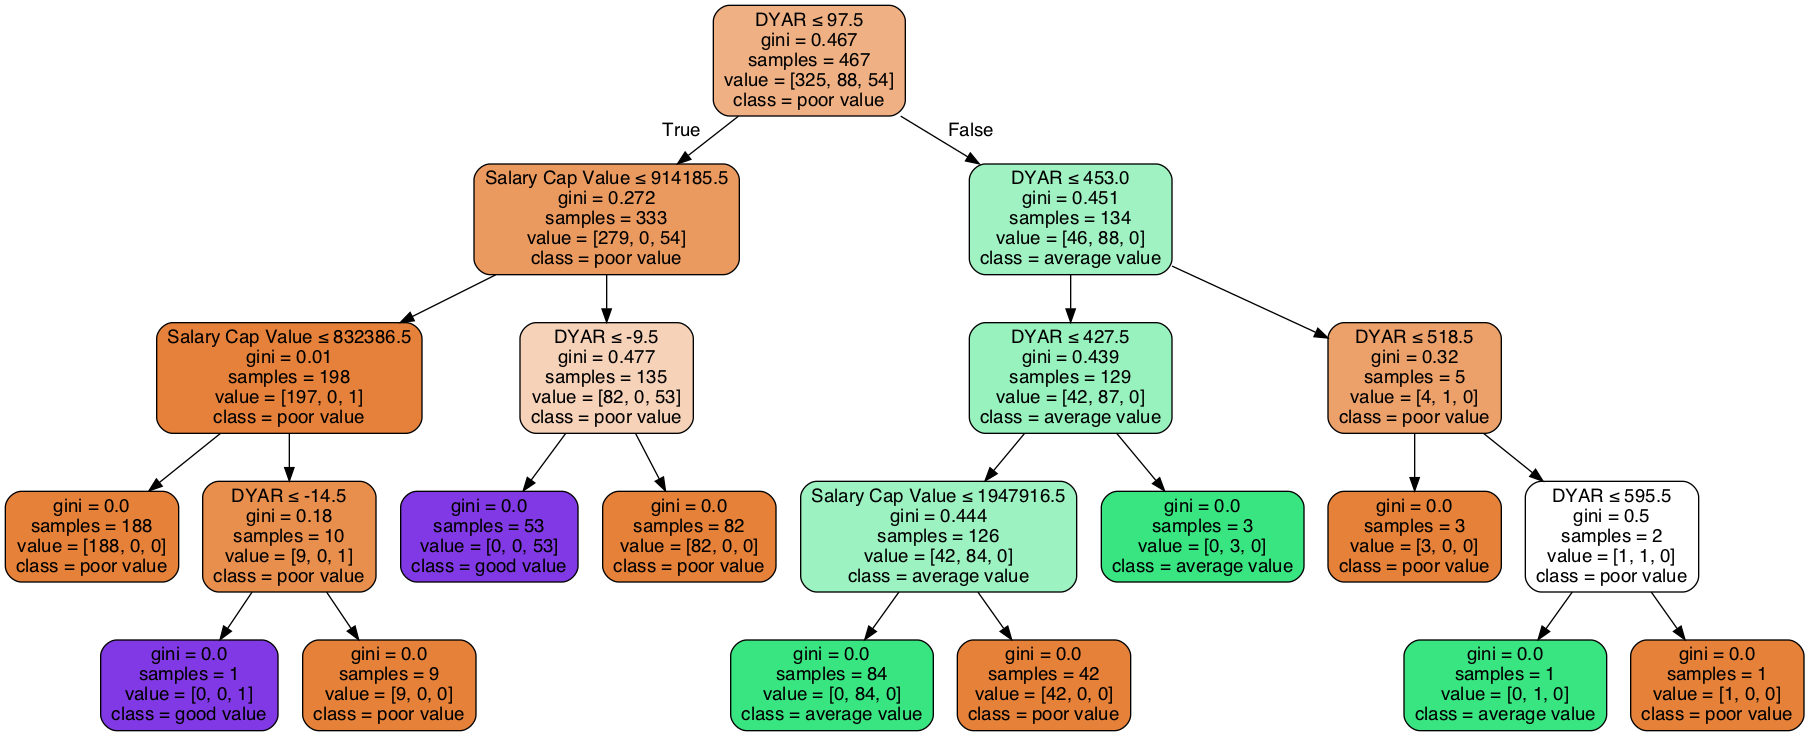

In [41]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['poor value', 'average value', 'good value'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Dtree.png')
Image(graph.create_png())

In [42]:
print("Accuracy on FA RB's:",metrics.accuracy_score(allFARB['class'], y_pred_FA))

Accuracy on FA RB's: 0.797752808988764


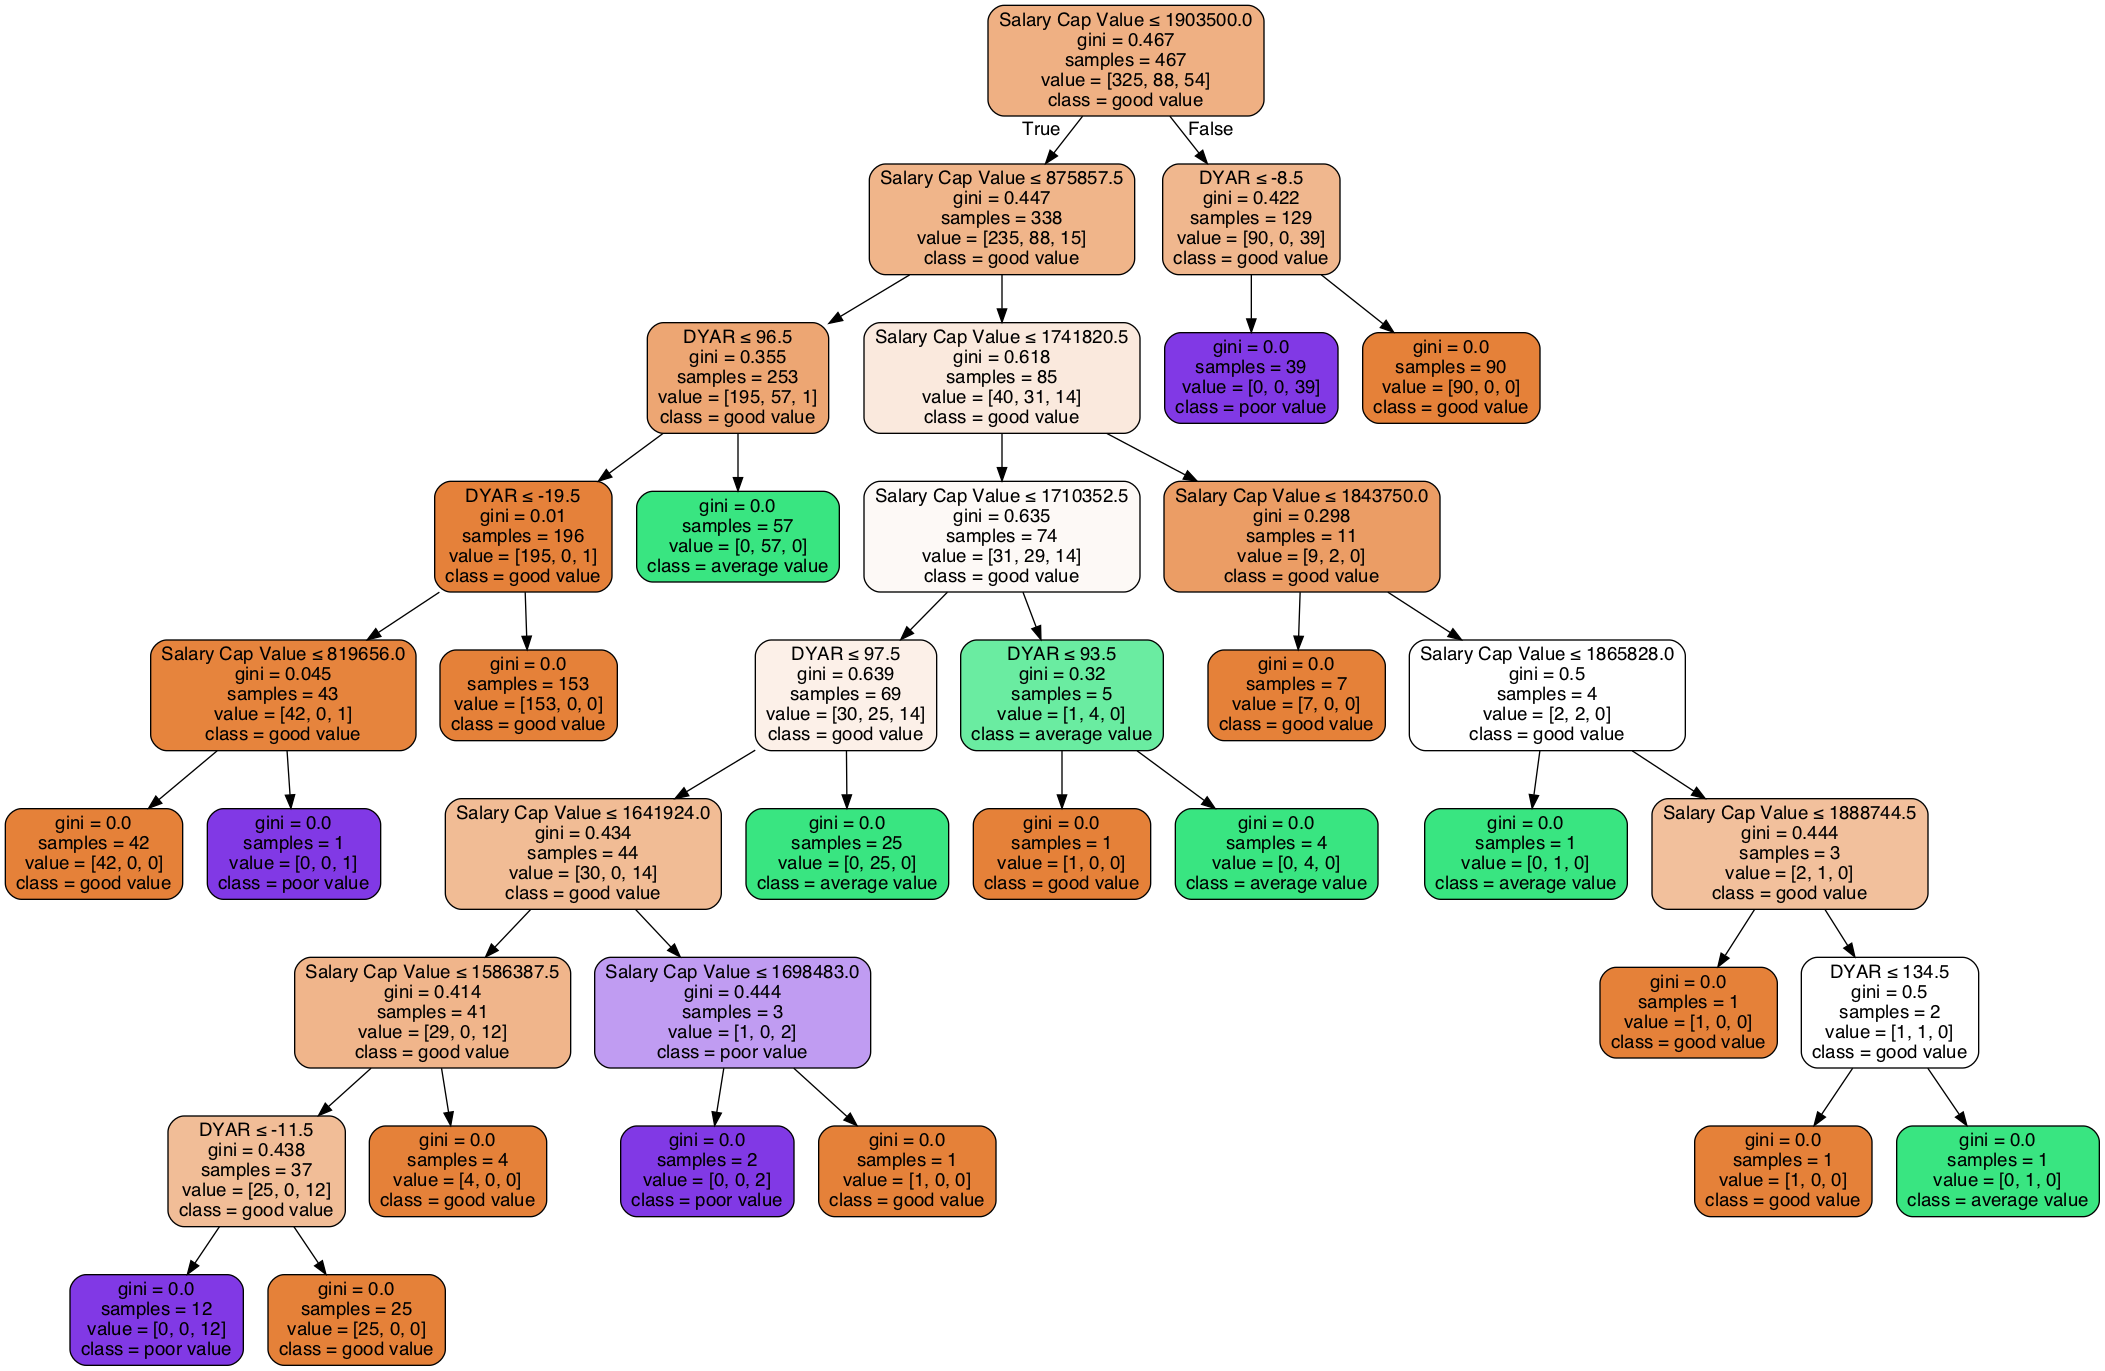

In [43]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['good value', 'average value', 'poor value'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [45]:
from sklearn import tree
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

feature_cols = ['DYAR', 'Salary Cap Value'] 

#big_data_amt_features = pd.concat([RB_big_board[features],allRookRB[features], allFARB[features]])
#big_data_amt_classes = pd.concat([RB_big_board['class'],allRookRB['class'], allFARB['class']])

#print((pd.concat([RB_big_board['DYAR'],allRookRB['DYAR'], allFARB['DYAR']])).quantile([0.1,0.2, 0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,1.0]))
#print((pd.concat([RB_big_board['AAV'],allRookRB['AAV'], allFARB['AAV']])).quantile([0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75, 0.8,0.9,1.0]))


X = np.array(RB_big_board[feature_cols])
y = np.array(RB_big_board['class'])

rook = np.array(allRookRB[features])
abc = np.array(allRookRB['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # 70% training and 30% test


print(y_test)
baseball=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=23, verbose=0,
            warm_start=False)
#clf = clf.fit(X_train,y_train)

['fair value' 'fair value' 'poor value' 'fair value' 'good value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'good value' 'poor value' 'fair value' 'fair value' 'fair value'
 'fair value' 'good value' 'fair value' 'poor value' 'fair value'
 'fair value' 'fair value' 'poor value' 'fair value' 'fair value'
 'good value' 'fair value' 'fair value' 'fair value' 'fair value'
 'good value' 'poor value' 'poor value' 'fair value' 'fair value'
 'fair value' 'good value' 'fair value' 'fair value' 'fair value'
 'fair value' 'good value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value']


In [46]:
baseball.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [47]:
FA_pred_forest = baseball.predict(testset_FA)

print(y_pred_FA)

['poor value' 'poor value' 'fair value' 'poor value' 'fair value'
 'fair value' 'fair value' 'good value' 'poor value' 'fair value'
 'poor value' 'good value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'poor value' 'poor value' 'fair value'
 'fair value' 'poor value' 'fair value' 'fair value' 'poor value'
 'fair value' 'fair value' 'fair value' 'good value' 'fair value'
 'poor value' 'fair value' 'poor value' 'poor value' 'poor value'
 'poor value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'poor value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'poor value' 'poor value' 'fair value'
 'fair value' 'fair value' 'fair value' 'poor value' 'fair value'
 'fair value' 'poor value' 'fair value' 'good value' 'good value'
 'good value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'poor value' 'fair value' 'fair value'
 'fair val

In [48]:
Rookie_pred_forest = baseball.predict(testset_Rook)

print(y_pred_rook)

['fair value' 'poor value' 'fair value' 'fair value' 'fair value'
 'good value' 'good value' 'fair value' 'fair value' 'good value'
 'fair value' 'fair value' 'fair value' 'fair value' 'good value'
 'fair value' 'fair value' 'fair value' 'fair value' 'good value'
 'fair value' 'good value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'good value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'good value' 'good value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'good value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair value' 'good value' 'fair value' 'good value' 'fair value'
 'fair value' 'fair value' 'fair value' 'fair value' 'fair value'
 'fair val

In [49]:
print("Accuracy on Rookie RB's:",metrics.accuracy_score(allRookRB['class'], Rookie_pred_forest))

Accuracy on Rookie RB's: 0.801980198019802


In [50]:
print("Accuracy on FA RB's:",metrics.accuracy_score(allFARB['class'], FA_pred_forest))

Accuracy on FA RB's: 0.8089887640449438


In [51]:
# Trying the Random Forest
estimator = baseball.estimators_[5]

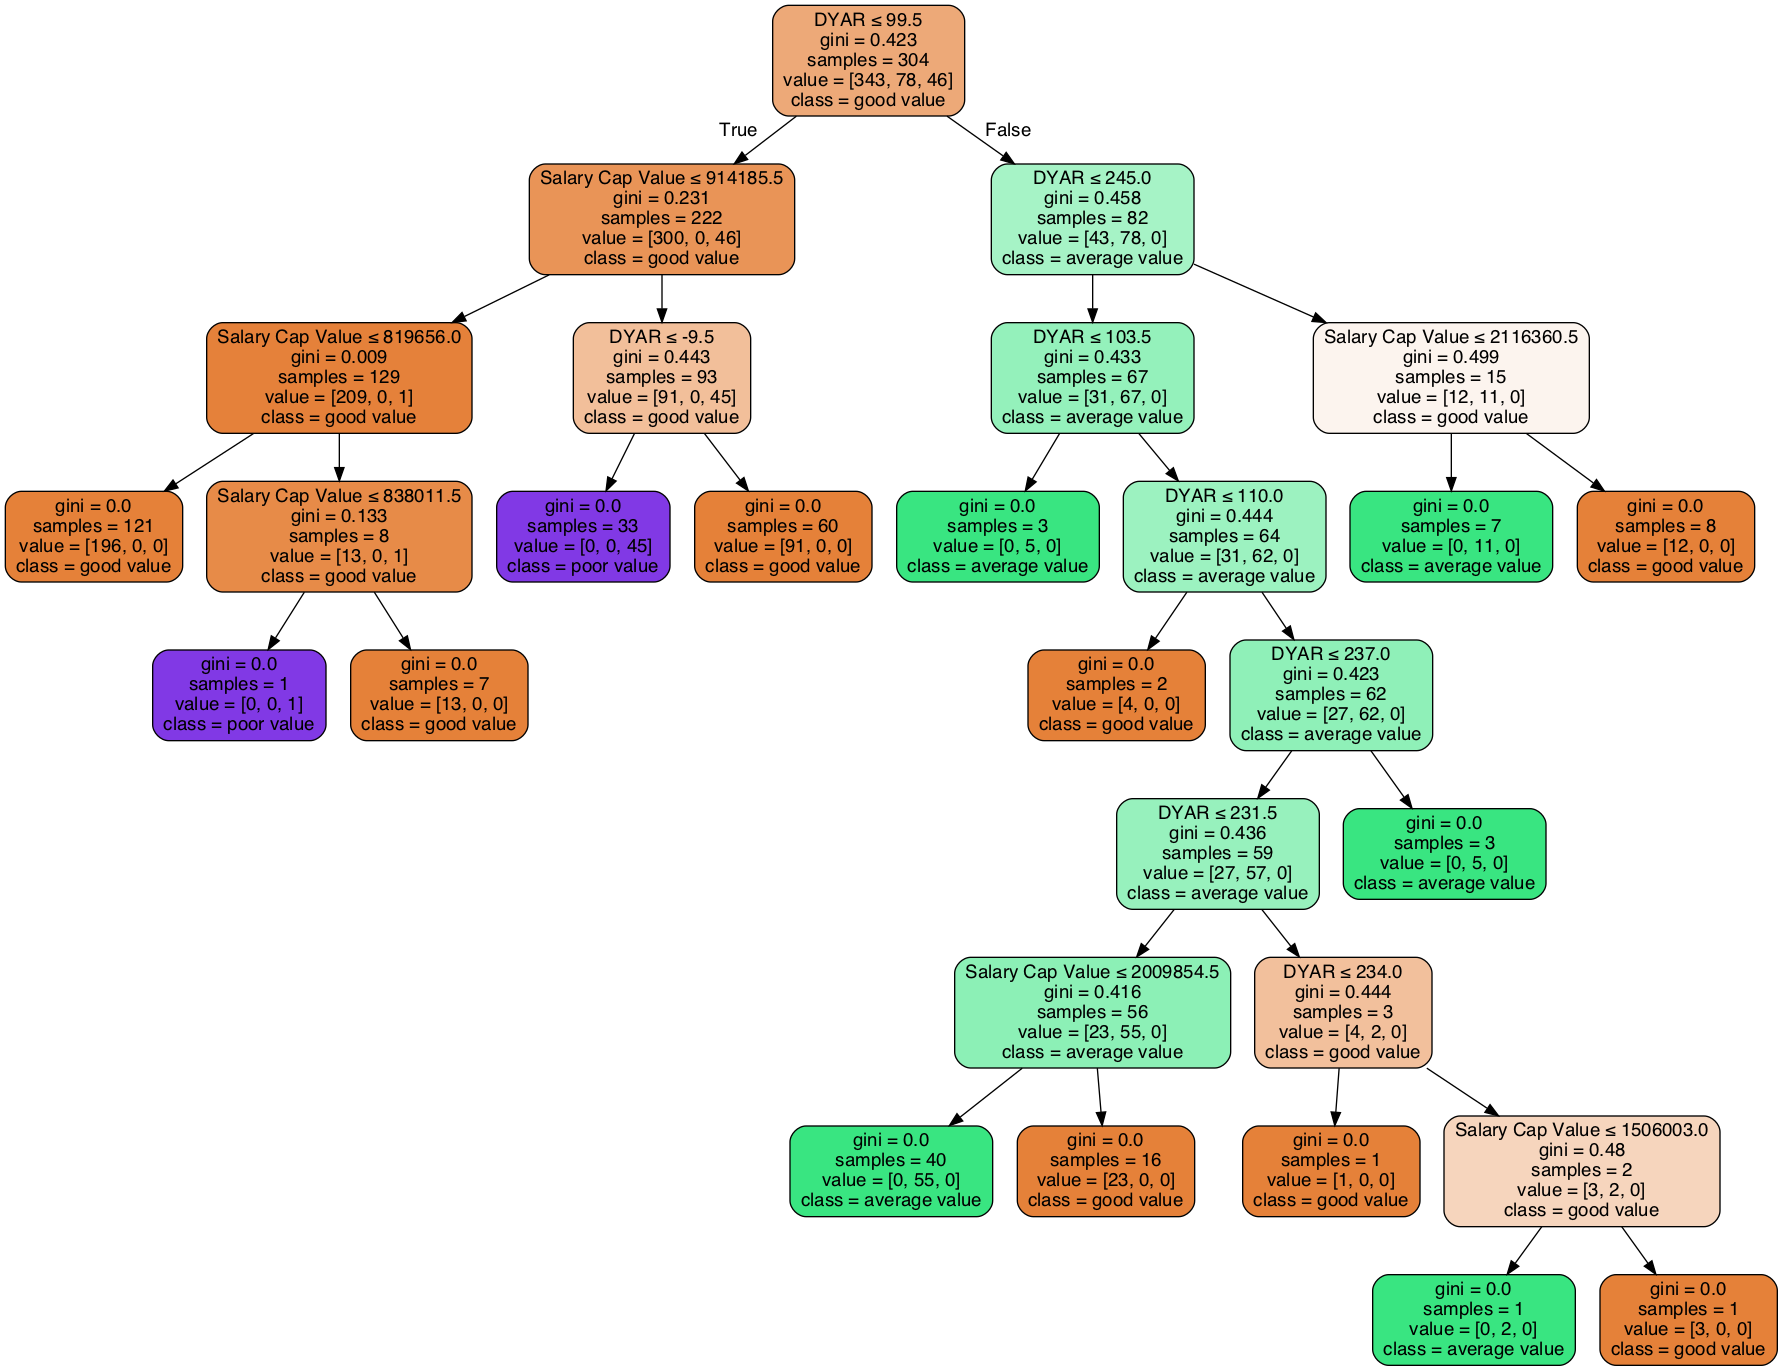

In [52]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['good value', 'average value', 'poor value'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [198]:
y_prede = clf.predict(testset_Rook)

In [199]:
print("Accuracy:",metrics.accuracy_score(allRookRB['class'], y_prede))

Accuracy: 0.8076923076923077


# Gurley Yearly breakdown

In [200]:
gurley2015 = Rookie_Rush_2015.loc[Rookie_Rush_2015['Player'] == 'Todd Gurley\GurlTo01', ['DYAR', 'AAV']]
gurley2015['SZN'] = 1

In [201]:
#gurley2015['DYAR'] = gurley2015['DYAR_x'] + gurley2016['DYAR_y']
print(gurley2015)

    DYAR         AAV  SZN
0  195.0  3455795.75    1


In [202]:
gurley2016 = RB_2016.loc[RB_2016['Player'] == 'Todd Gurley\GurlTo01', ['DYAR_x','DYAR_y', 'Salary Cap Value']]

In [203]:
gurley2016['DYAR'] = gurley2016['DYAR_x'] + gurley2016['DYAR_y']
gurley2016['SZN'] = 2

In [204]:
print(gurley2016)

    DYAR_x  DYAR_y  Salary Cap Value  DYAR  SZN
36     -66    13.0         3141632.0 -53.0    2


In [205]:
gurley2017 = RB_2017.loc[RB_2017['Player'] == 'Todd Gurley\GurlTo01',  ['DYAR_x','DYAR_y', 'Salary Cap Value']]

In [206]:
gurley2017['DYAR'] = gurley2017['DYAR_x'] + gurley2017['DYAR_y']
gurley2017['SZN'] = 3

In [207]:
print(gurley2017)

   DYAR_x  DYAR_y  Salary Cap Value   DYAR  SZN
1     268   236.0         3769958.0  504.0    3


In [208]:
gurley2018 = RB_2018.loc[RB_2018['Player'] == 'Todd Gurley\GurlTo01',['DYAR_x','DYAR_y', 'Salary Cap Value']]

In [209]:
gurley2018['DYAR'] = gurley2018['DYAR_x'] + gurley2018['DYAR_y']
gurley2018['SZN'] = 4

In [210]:
print(gurley2018)


   DYAR_x  DYAR_y  Salary Cap Value   DYAR  SZN
0     367    98.0         7228306.0  465.0    4


In [211]:
gurley_DYAR = pd.concat([gurley2015['DYAR'], gurley2016['DYAR'], gurley2017['DYAR'], gurley2018['DYAR']])
gurley_AAV = pd.concat([gurley2015['AAV'], gurley2016['Salary Cap Value'], gurley2017['Salary Cap Value'], gurley2018['Salary Cap Value']])
gurley_SZN = pd.concat([gurley2015['SZN'], gurley2016['SZN'], gurley2017['SZN'], gurley2018['SZN']])

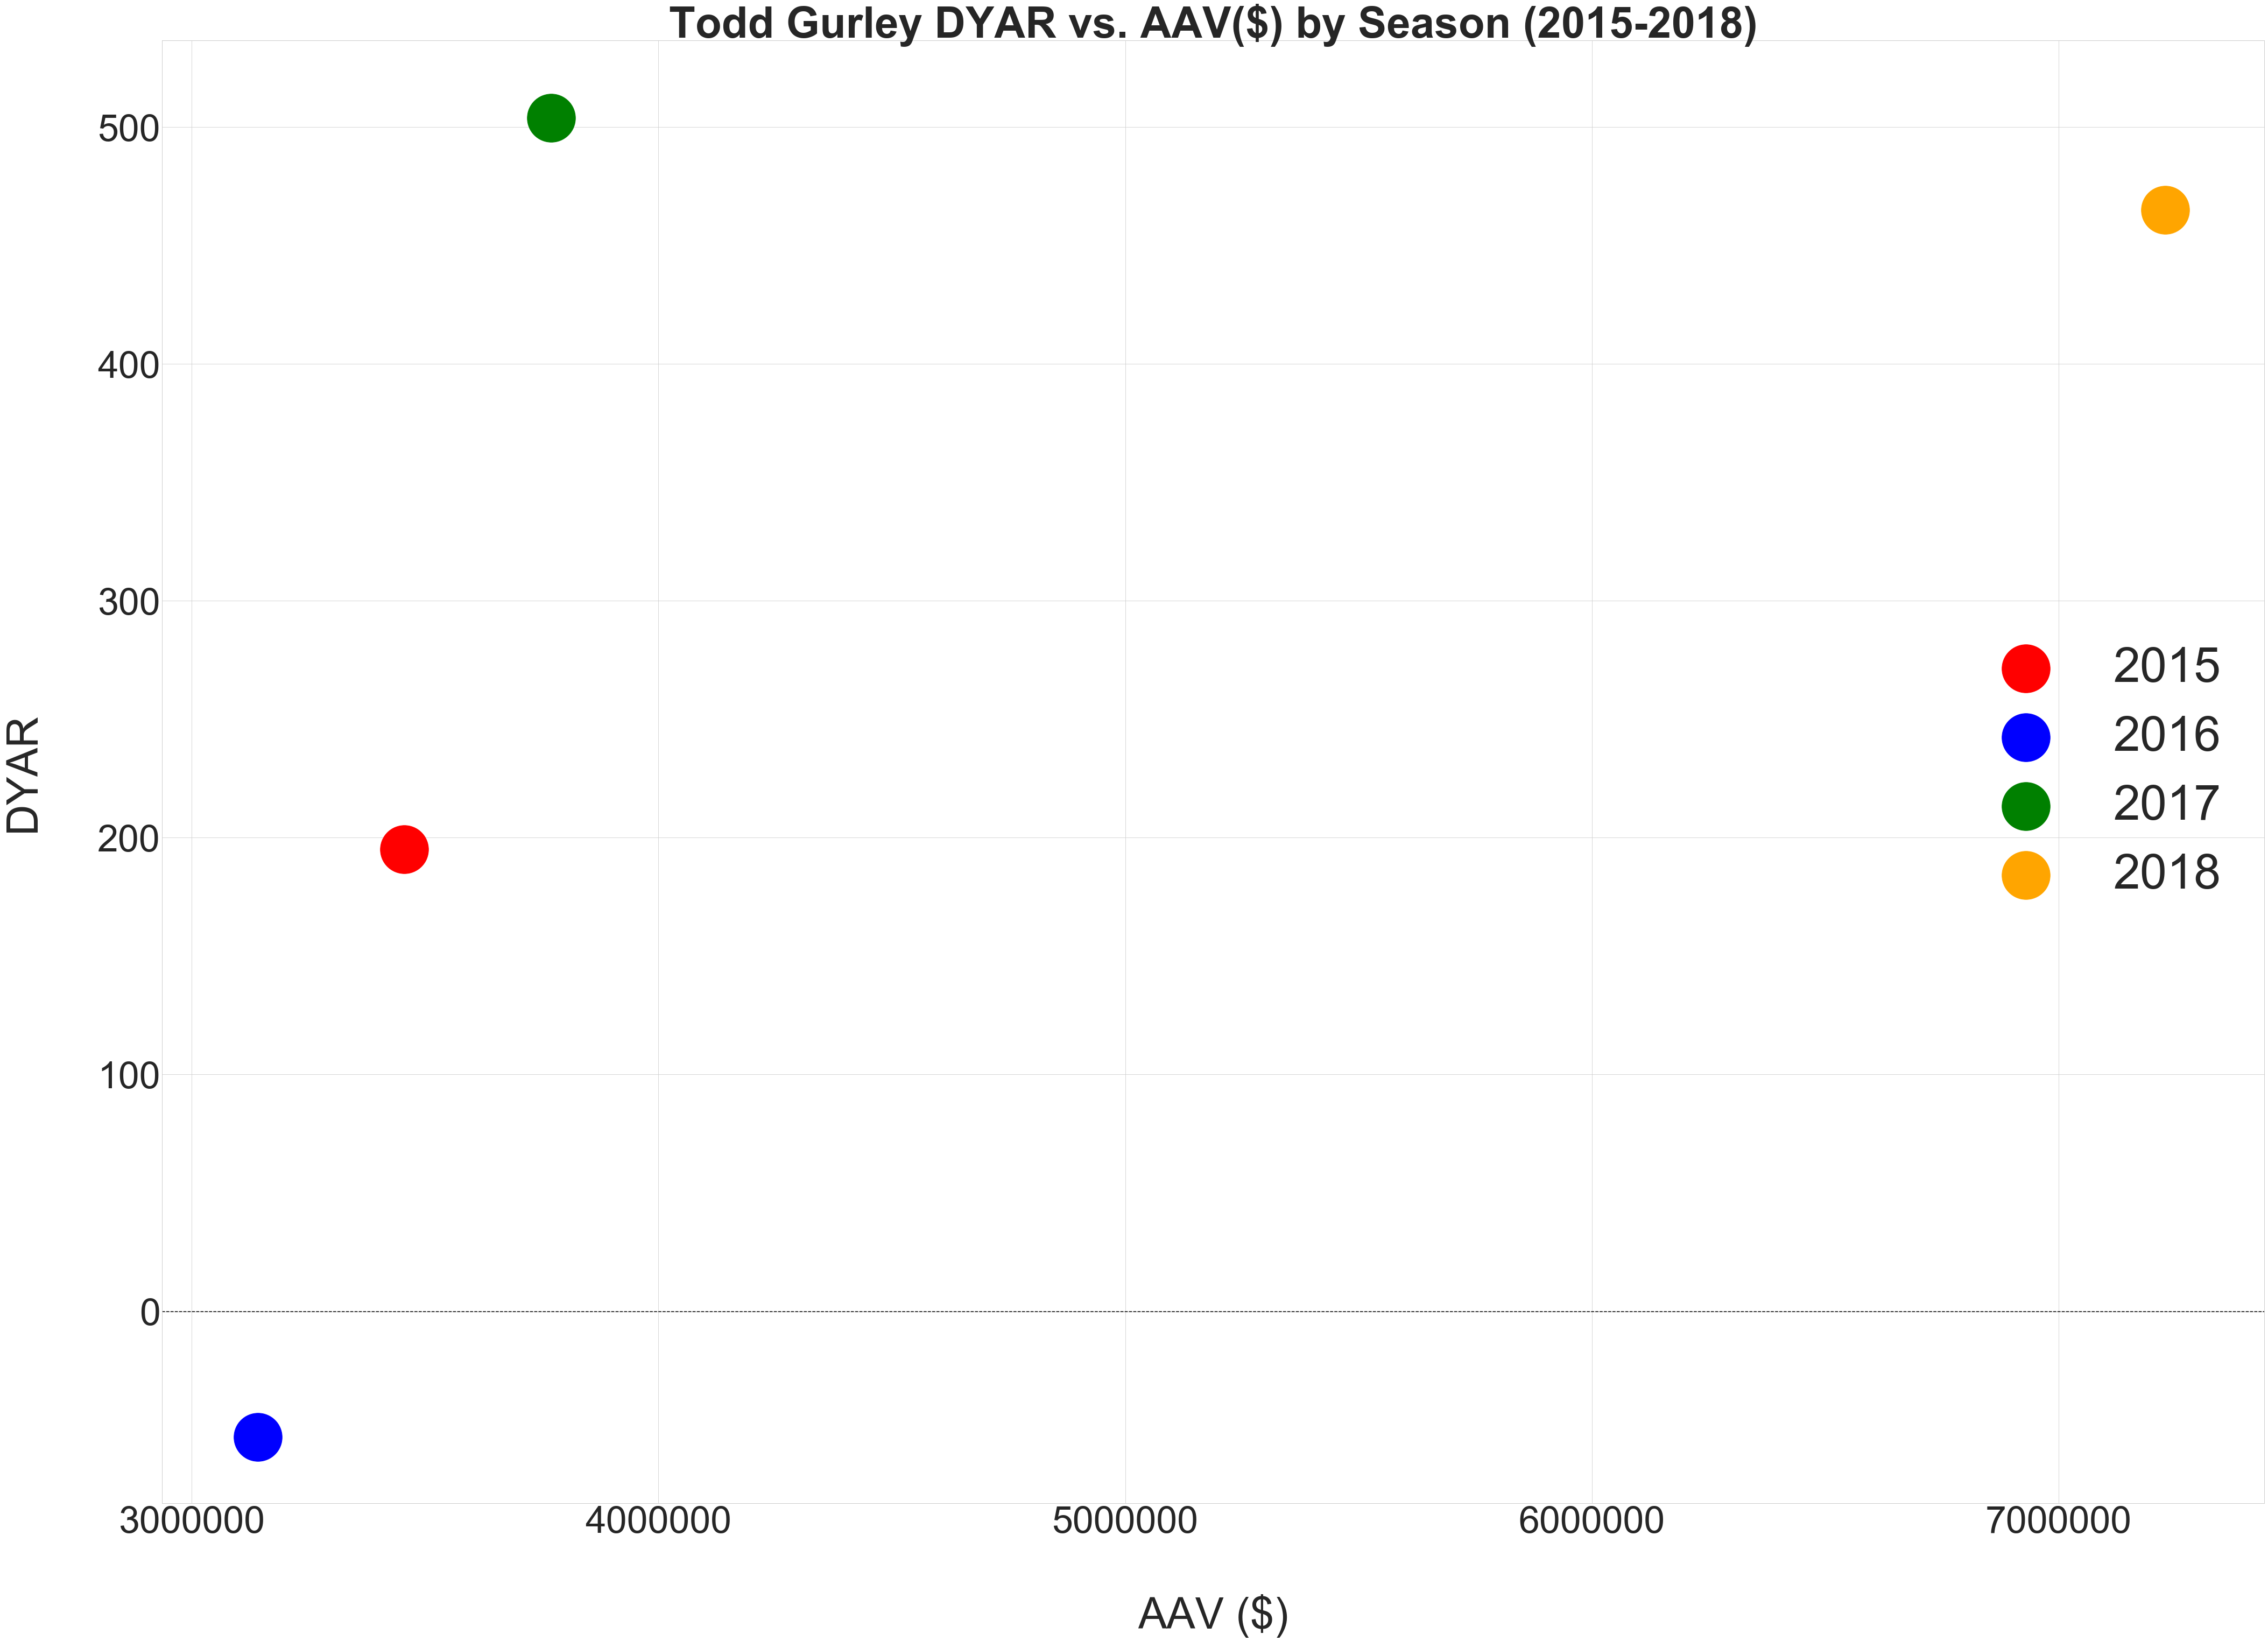

In [216]:
fig = plt.figure(figsize=(70, 50))

xs = np.array(gurley_AAV)
ys = np.array(gurley_DYAR)
labels = np.array(gurley_SZN)

#Avg_DYAR = statistics.mean(y)
#print(Avg_DYAR)


labels_masks =( (x,(labels == x)) for x in set(labels))
data_dict = dict( (lbl,(xs[mask],ys[mask])) for lbl,mask in labels_masks )

#print(labels_masks)

label_dict = {1: 'r', 2: 'b', 3: 'green', 4: 'orange'}
legend_dict = {1: '2015', 2: '2016', 3: '2017', 4: '2018'}

for label,data in data_dict.items():
    x,y = data
    plt.scatter(x,y,c=label_dict.get(label),label=legend_dict.get(label), linestyle='-',s = 8000)
    #plt.plot(x, y, c=label_dict.get(label),label=legend_dict.get(label), linestyle='-',marker = 'o')

plt.legend(loc=5,prop={'size': 90})
plt.title('Todd Gurley DYAR vs. AAV($) by Season (2015-2018)', fontsize = 80,fontweight='bold')
plt.xlabel('AAV ($)', fontsize=80, labelpad=100)
plt.ylabel('DYAR', fontsize=80, labelpad=100)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)

#plt.axvline(x=lowest_sal_16, color='k', linestyle='--')
plt.axhline(y = 0, color='k', linestyle='--')


plt.savefig('gurley4year.png')

plt.show()

   DYAR         AAV  SZN
1 -73.0  2667443.25    1
    DYAR_x  DYAR_y  Salary Cap Value   DYAR  SZN
28       2   105.0         2424946.0  107.0    2
    DYAR_x  DYAR_y  Salary Cap Value  DYAR  SZN
28      21    76.0         2909935.0  97.0    3
   DYAR_x  DYAR_y  Salary Cap Value   DYAR  SZN
4     208    72.0         3394924.0  280.0    4


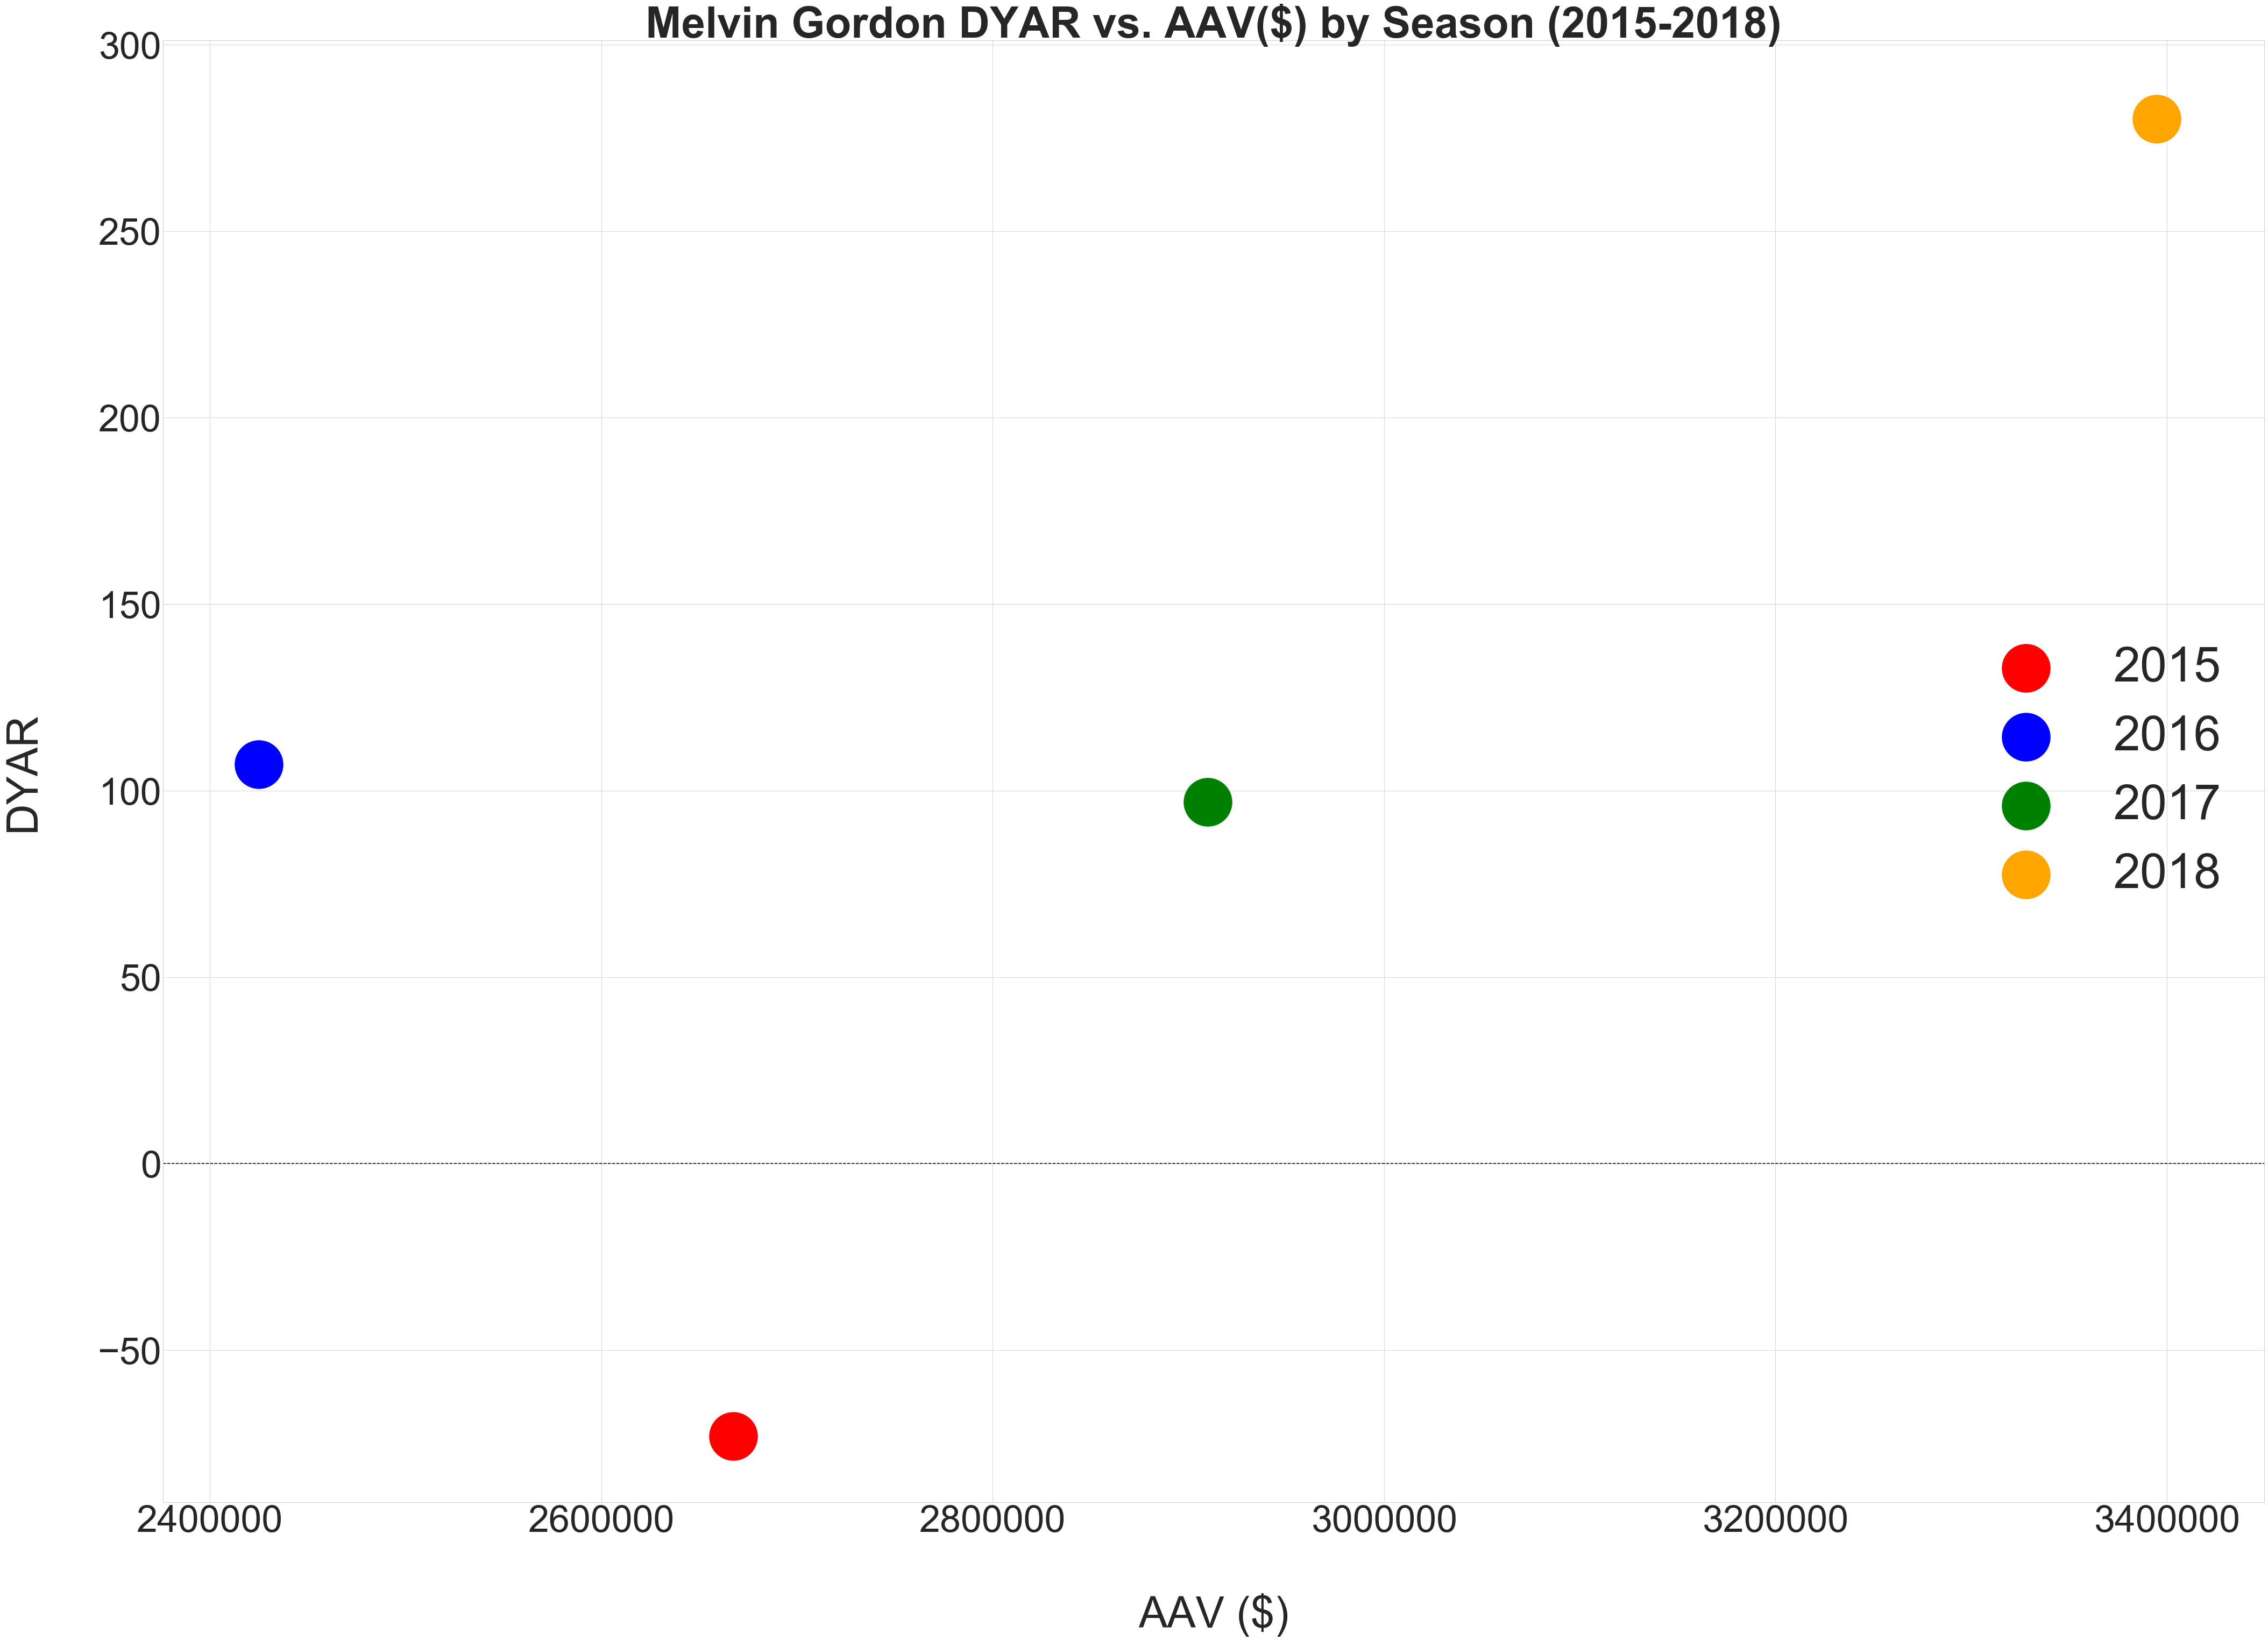

In [215]:
gordon2015 = Rookie_Rush_2015.loc[Rookie_Rush_2015['Player'] == 'Melvin Gordon\GordMe00', ['DYAR', 'AAV']]
gordon2015['SZN'] = 1

#gordon2015['DYAR'] = gordon2015['DYAR_x'] + gordon2016['DYAR_y']
print(gordon2015)

gordon2016 = RB_2016.loc[RB_2016['Player'] == 'Melvin Gordon\GordMe00', ['DYAR_x','DYAR_y', 'Salary Cap Value']]

gordon2016['DYAR'] = gordon2016['DYAR_x'] + gordon2016['DYAR_y']
gordon2016['SZN'] = 2

print(gordon2016)

gordon2017 = RB_2017.loc[RB_2017['Player'] == 'Melvin Gordon\GordMe00',  ['DYAR_x','DYAR_y', 'Salary Cap Value']]

gordon2017['DYAR'] = gordon2017['DYAR_x'] + gordon2017['DYAR_y']
gordon2017['SZN'] = 3

print(gordon2017)

gordon2018 = RB_2018.loc[RB_2018['Player'] == 'Melvin Gordon\GordMe00',['DYAR_x','DYAR_y', 'Salary Cap Value']]

gordon2018['DYAR'] = gordon2018['DYAR_x'] + gordon2018['DYAR_y']
gordon2018['SZN'] = 4

print(gordon2018)




gordon_DYAR = pd.concat([gordon2015['DYAR'], gordon2016['DYAR'], gordon2017['DYAR'], gordon2018['DYAR']])
gordon_AAV = pd.concat([gordon2015['AAV'], gordon2016['Salary Cap Value'], gordon2017['Salary Cap Value'], gordon2018['Salary Cap Value']])
gordon_SZN = pd.concat([gordon2015['SZN'], gordon2016['SZN'], gordon2017['SZN'], gordon2018['SZN']])

fig = plt.figure(figsize=(70, 50))

xs = np.array(gordon_AAV)
ys = np.array(gordon_DYAR)
labels = np.array(gordon_SZN)

#Avg_DYAR = statistics.mean(y)
#print(Avg_DYAR)


labels_masks =( (x,(labels == x)) for x in set(labels))
data_dict = dict( (lbl,(xs[mask],ys[mask])) for lbl,mask in labels_masks )

#print(labels_masks)

label_dict = {1: 'r', 2: 'b', 3: 'green', 4: 'orange'}
legend_dict = {1: '2015', 2: '2016', 3: '2017', 4: '2018'}

for label,data in data_dict.items():
    x,y = data
    plt.scatter(x,y,c=label_dict.get(label),label=legend_dict.get(label), linestyle='-',s = 8000)
    #plt.plot(x, y, c=label_dict.get(label),label=legend_dict.get(label), linestyle='-',marker = 'o')

plt.legend(loc=5,prop={'size': 90})
plt.title('Melvin Gordon DYAR vs. AAV($) by Season (2015-2018)', fontsize = 80,fontweight='bold')
plt.xlabel('AAV ($)', fontsize=80, labelpad=100)
plt.ylabel('DYAR', fontsize=80, labelpad=100)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)

#plt.axvline(x=lowest_sal_16, color='k', linestyle='--')
plt.axhline(y = 0, color='k', linestyle='--')


plt.savefig('Gordon4year.png')

plt.show()

In [217]:
# QB Statistics
Passing_2017 = pd.read_csv('2017_NFL_Passing.csv')
Passing_2017['Player'] = Passing_2017['Player'].str.replace(r'[*,+]', '')

# RB/WR Statistics
Rushing_2017 = pd.read_csv('2017_NFL_Rushing.csv')
Rushing_2017['Player'] = Rushing_2017['Player'].str.replace(r'[*,+]', '')

Receiving_2017 = pd.read_csv('2017_NFL_Recieving.csv')
Receiving_2017['Player'] = Receiving_2017['Player'].str.replace(r'[*,+]', '') 

QB_Salary_2017 = pd.read_csv('QB_2017_Sal.csv')
QB_Salary_2017['Player'] = QB_Salary_2017['Player'].str.replace(r'[*,+]', '') 

RB_Salary_2017 = pd.read_csv('RB_2017_Sal.csv')
RB_Salary_2017['Player'] = RB_Salary_2017['Player'].str.replace(r'[*,+]', '')

WR_Salary_2017 = pd.read_csv('WR_2017_Sal.csv')
WR_Salary_2017['Player'] = WR_Salary_2017['Player'].str.replace(r'[*,+]', '') 

TE_Salary_2017 = pd.read_csv('TE_2017_Sal.csv')
TE_Salary_2017['Player'] = TE_Salary_2017['Player'].str.replace(r'[*,+]', '') 

#This has DOVA and other metrics
QB_FO_2017 = pd.read_csv('QB_2017_FO_Stats.csv')
QB_FO_2017['Player'] = QB_FO_2017['Player'].str.replace(r'[*,+]', '') 

RUSH_FO_2017 = pd.read_csv('RB_2017_FO_Stats.csv')
RUSH_FO_2017['Player'] = RUSH_FO_2017['Player'].str.replace(r'[*,+]', '') 

REC_FO_2017 = pd.read_csv('REC_2017_FO_Stats.csv') #all reception stats are here
REC_FO_2017['Player'] = REC_FO_2017['Player'].str.replace(r'[*,+]', '') 

#is_RB = (Rushing_2017['Pos'] == 'RB')
#Rushing_2017 = Rushing_2017[is_RB]

#need receiving (filter by RBs)

positional_spend_2017 = pd.read_csv('positional_spending_2017.csv')
AV_2017 = pd.read_csv('AV_2017.csv')
AV_2017['Player'] = AV_2017['Player'].str.replace(r'[*,+]', '') 

RB_Salary_2017

Player        Team  Salary Cap Value  Cash Spent
0           Le'Veon Bell\BellLe00    Steelers        12120000.0  12120000.0
1           LeSean McCoy\McCoLe01       Bills        10375000.0   6250000.0
2         DeMarco Murray\MurrDe00      Titans         6950000.0   6250000.0
3           Lamar Miller\MillLa01      Texans         6500000.0   5500000.0
4       Jonathan Stewart\StewJo00    Panthers         6175000.0   4218750.0
5            Chris Ivory\IvorCh00     Jaguars         6000000.0   5000000.0
6            Doug Martin\MartDo00  Buccaneers         5764706.0   5764706.0
7            Mark Ingram\IngrMa01      Saints         5345000.0   3700000.0
8        Ezekiel Elliott\ElliEz00     Cowboys         5112702.0   1025186.0
9             Matt Forte\FortMa00        Jets         5000000.0   4000000.0
10     Leonard Fournette\FourLe00     Jaguars         4936524.0  18351096.0
11          Bilal Powell\PoweBi00        Jets         4633333.0   3750000.0
12       Devonta Freeman\FreeDe00     Falcons         4418106.0  16297000.0
13          Shane Vereen\VereSh00      Giants         4416668.0   3450000.0
14        Darren Sproles\SproDa00      Eagles         4000000.0   4000000.0
15        Mike Gillislee\GillMi00    Patriots         3968750.0   3781250.0
16           Todd Gurley\GurlTo01        Rams         3769958.0   1691652.0
17       Giovani Bernard\BernGi00     Bengals         3675000.0   3000000.0
18            Eddie Lacy\LacyEd00    Seahawks         3562500.0   4250000.0
19            Frank Gore\GoreFr00       Colts         3500000.0   3500000.0
20          Rex Burkhead\BurkRe00    Patriots         3150000.0   3150000.0
21   Christian McCaffrey\McCaCh01    Panthers         3134782.0  11144128.0
22         C.J. Anderson\AndeC.00     Broncos         3000000.0   3000000.0
23       Latavius Murray\MurrLa00     Vikings         2956250.0   4250000.0
24         Melvin Gordon\GordMe00    Chargers         2909935.0   1404978.0
25        Isaiah Crowell\CrowIs00      Browns         2746000.0   2746000.0
26        Marshawn Lynch\LyncMa00     Raiders         2701838.0   4289338.0
27        Chris Thompson\ThomCh03    Redskins         2500000.0   4500000.0
28          Theo Riddick\RiddTh00       Lions         2400000.0   1475000.0
29         Alfred Morris\MorrAl00     Cowboys         2137500.0   1700000.0
..                            ...         ...               ...         ...
149          Kapri Bibbs\BibbKa00    Redskins          108529.0    108529.0
150                 John Crockett      Ravens          108000.0    108000.0
151           George Atkinson III      Chiefs          108000.0    108000.0
152                 Brandon Wilds     Jaguars           86400.0     86400.0
153              Jarveon Williams     Bengals           82059.0     82059.0
154                    Akeem Judd        Jets           75177.0     75177.0
155        Stevan Ridley\RidlSt00    Steelers           72353.0     91176.0
156               Jeremy Langford        Jets           67200.0     67200.0
157                   Elijah Hood     Raiders           64800.0     64800.0
158         Bronson Hill\HillBr01   Cardinals           63529.0     63529.0
159               Dare Ogunbowale    Redskins           54706.0     54706.0
160                   Josh Rounds      Browns           50400.0     50400.0
161                Troymaine Pope      Texans           43200.0     43200.0
162        Marcus Murphy\MurpMa03       Bills           36176.0     36176.0
163              Brandon Radcliff    Dolphins           36000.0     36000.0
164                 Darius Victor   Cardinals           36000.0     36000.0
165       Terrell Watson\WatsTe00    Steelers           36000.0     36000.0
166               Russ Hansbrough    Chargers           31765.0     31765.0
167                Terrence Magee     Falcons           28800.0     28800.0
168                  Jahad Thomas        Jets           27353.0     27353.0
169             Khalfani Muhammad      Titans           27353.0     27353.0

#### 2018 DATA

In [212]:
# 2018 DATA

# QB Statistics
Passing_2018 = pd.read_csv('2018_NFL_Passing.csv')
Passing_2018['Player'] = Passing_2018['Player'].str.replace(r'[*,+]', '')

# RB/WR Statistics
Rushing_2018 = pd.read_csv('2018_NFL_Rushing.csv')
Rushing_2018['Player'] = Rushing_2018['Player'].str.replace(r'[*,+]', '')
Receiving_2018 = pd.read_csv('2018_NFL_Recieving.csv')
Receiving_2018['Player'] = Receiving_2018['Player'].str.replace(r'[*,+]', '') 

QB_Salary_2018 = pd.read_csv('QB_2018_Sal.csv')
RB_Salary_2018 = pd.read_csv('RB_2018_Sal.csv')
WR_Salary_2018 = pd.read_csv('WR_2018_Sal.csv')
TE_Salary_2018 = pd.read_csv('TE_2018_Sal.csv')

#This has DOVA and other metrics
QB_FO_2018 = pd.read_csv('QB_2018_FO_Stats.csv')
RUSH_FO_2018 = pd.read_csv('RB_2018_FO_Stats.csv')
REC_FO_2018 = pd.read_csv('REC_2018_FO_Stats.csv') #all reception stats are here

#is_RB = (Rushing_2018['Pos'] == 'RB')
#Rushing_2018 = Rushing_2018[is_RB]

#need receiving (filter by RBs)

positional_spend_2018 = pd.read_csv('positional_spending_2018.csv')

#will probably use AV to determine on field production
AV_2018 = pd.read_csv('AV_2018.csv')

AV_2018.head()
RUSH_FO_2018.head()

Player Team  DYAR  YAR    DVOA     VOA  Runs  Yards  \
0   Todd Gurley*+\GurlTo01  LAR   367  341  23.70%  21.40%   256  1,251   
1   Derrick Henry\HenrDe00  TEN   280  233  23.10%  17.70%   215  1,059   
2   Alvin Kamara*\KamaAl00   NO   237  280  18.50%  23.40%   194    896   
3     Marlon Mack\MackMa00  IND   215  176  16.60%  12.10%   195    912   
4  Melvin Gordon*\GordMe00  LAC   208  238  20.50%  24.80%   175    885   

    EYds  TD  FUM  
0  1,573  17    0  
1  1,217  12    0  
2  1,138  14    0  
3  1,082   9    1  
4    952  10    0

## Creating same 'Players' Field in all files for easy merging of Datasets

In [40]:
# feed in 
# col is the list of short names

# THIS WILL ONLY REPLACE PLAYERS THAT APPEAR IN THE TABLE (Obviously)
def standardize_names(col, df):
    for i in df['Player']: # this should be the players string name
        for j in col:
            Partial_Ratio = fuzz.partial_ratio(str(i) ,str(j))
            if (Partial_Ratio > 90):
                col = col.replace(j, i) 
    return col


#Example: changing Tyler Locket to Tyler Lockett/TLock00
new_names = standardize_names(QB_Salary_2018['Player'], QB_FO_2018)
QB_Salary_2018['Player'] = new_names


QB_Salary_2018.head()

#QB_Salary_2018.to_csv('QB_2018_Sal.csv') 

Player      Team   \tSalary Cap Value    \tCash Spent
0   Jimmy Garoppolo\GaroJi00     49ers              37000000  \t$41,950,000
1  Matthew Stafford\StafMa00     Lions              26500000       16500000
2        Derek Carr\CarrDe02   Raiders              25000000       22500000
3        Joe Flacco\FlacJo00    Ravens              24750000  \t$12,000,000
4       Andrew Luck\LuckAn00     Colts              24400000  \t$18,000,000

# Generating new columns for analysis

## 2017 Rushing Data Merging to get AV in same table 

Procedure:
    1. Merge Football Outsider Data with Pro Football Reference AV table
    2. Merge that table with 2017 RB salaries
    3. add a column of production vs. salary for that year
    4. Look at production clusters vs. salary clusters vs. prod/salary cluster

In [153]:
#Rushing_2017


Rush = RUSH_FO_2017.merge(RB_Salary_2017, how='left',on='Player')
Rush = Rush.merge(REC_FO_2017, how='left',on='Player')

Rush['DYAR'] = Rush['DYAR_x'] + Rush['DYAR_y']


print(np.quantile(Rush['DYAR'], 0.25), np.quantile(Rush['Salary Cap Value'], 0.25))
print(np.quantile(Rush['DYAR'], 0.5), np.quantile(Rush['Salary Cap Value'], 0.5))
print(np.quantile(Rush['DYAR'], 0.75), np.quantile(Rush['Salary Cap Value'], 0.75))
print(np.quantile(Rush['DYAR'], 1.), np.quantile(Rush['Salary Cap Value'], 1.))

# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
 
# Delete these row indexes from dataFrame
#Rush.drop(indexNames , inplace=True)
Rush.sort_values(by=['DYAR'], ascending=False)

nan nan
nan nan
nan nan
nan nan


/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Player Team_x  DYAR_x  YAR_x   DVOA  VOA_x  Runs  \
2          Alvin Kamara\KamaAl00     NO     255    255  0.445  0.444   120   
1           Todd Gurley\GurlTo01   LARM     268    205  0.139  0.086   279   
0            Dion Lewis\LewiDi00     NE     273    280  0.276  0.286   180   
3           Kareem Hunt\HuntKa00     KC     222    248  0.119  0.143   272   
4          Le'Veon Bell\BellLe00    PIT     214    261  0.079  0.115   321   
69       Chris Thompson\ThomCh03    WAS       9      8 -0.049 -0.052    64   
6       Ezekiel Elliott\ElliEz00    DAL     205    198  0.111  0.105   242   
7           Mark Ingram\IngrMa01     NO     193    210  0.112  0.128   230   
48         Duke Johnson\JohnDu00    CLE      90     92  0.157  0.161    81   
11      Jamaal Williams\WillJa06     GB     108     86  0.074  0.041   153   
13      Devonta Freeman\FreeDe00    ATL      89    105  0.015  0.034   195   
20         Lamar Miller\MillLa01    HOU      57     42 -0.028 -0.044   238   
10    Leonard Fournette\FourLe00    JAC     115     57  0.021 -0.033   268   
53         Rex Burkhead\BurkRe00     NE      56     65  0.105  0.136    64   
52        Austin Ekeler\EkelAu00   LACH      59     61  0.227  0.240    47   
8        Marshawn Lynch\LyncMa00    OAK     165    131  0.101  0.063   207   
33  Christian McCaffrey\McCaCh01    CAR      11     14 -0.062 -0.056   117   
31        Tevin Coleman\ColeTe01    ATL      14      9 -0.065 -0.072   156   
49            Rod Smith\SmitRo06    DAL      81     82  0.239  0.242    55   
51        Corey Clement\ClemCo00    PHI      71     71  0.145  0.143    74   
5          Alex Collins\CollAl00    BAL     205    181  0.151  0.123   212   
14          Matt Breida\BreiMa00     SF      87     79  0.130  0.111   104   
62        Jalen Richard\RichJa01    OAK      15     15 -0.014 -0.014    56   
17           Frank Gore\GoreFr00    IND      66     46 -0.023 -0.042   261   
9         Jordan Howard\HowaJo00    CHI     160    122  0.058  0.024   276   
28        Melvin Gordon\GordMe00   LACH      21     30 -0.068 -0.060   284   
21        Derrick Henry\HenrDe00    TEN      56     37 -0.012 -0.037   176   
12       Javorius Allen\AlleJa01    BAL      96     67  0.062  0.018   153   
78          James White\WhitJa02     NE      -1      8 -0.093 -0.036    43   
47          Aaron Jones\JoneAa00     GB     143    134  0.313  0.287    81   
..                           ...    ...     ...    ...    ...    ...   ...   
84         Mike Tolbert\TolbMi00    BUF      -9    -31 -0.121 -0.210    66   
89         Paul Perkins\PerkPa00    NYG     -29    -39 -0.271 -0.336    41   
94       Elijah McGuire\McGuEl00    NYJ     -56    -38 -0.258 -0.203    88   
87         Shane Vereen\VereSh00    NYG     -22    -13 -0.226 -0.165    45   
93   DeAndre Washington\WashDe00    OAK     -55    -34 -0.331 -0.239    57   
96         Thomas Rawls\RawlTh00    SEA     -83    -86 -0.409 -0.418    58   
73          Tarik Cohen\CoheTa00    CHI       6      4 -0.068 -0.073    87   
90       Branden Oliver\OlivBr01   LACH     -32    -35 -0.314 -0.334    35   
42         Bilal Powell\PoweBi00    NYJ     -43      5 -0.148 -0.079   178   
43     Jonathan Stewart\StewJo00    CAR     -54    -34 -0.148 -0.126   198   
44          Doug Martin\MartDo00     TB     -77    -83 -0.225 -0.235   138   
45      Adrian Peterson\PeteAd01    2TM     -85    -79 -0.219 -0.209   156   
15        Alfred Morris\MorrAl00    DAL      79     99  0.084  0.126   115   
25       Mike Gillislee\GillMi00     NE      39     58 -0.008  0.031   104   
36    LeGarrette Blount\BlouLe00    PHI      -9     -5 -0.098 -0.092   173   
50          Corey Grant\GranCo00    JAC      79     75  0.536  0.511    30   
56        Stevan Ridley\RidlSt00    PIT      34     12  0.271  0.043    26   
57         Chris Carson\CarsCh00    SEA      33     21  0.070  0.013    49   
58        Elijhaa Penny\PennEl00    ARI      33     44  0.158  0.241    31   
60         James Conner\ConnJa00    PIT      20 

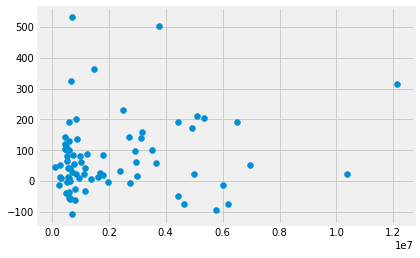

In [155]:
plt.scatter(x=Rush['Salary Cap Value'], y = Rush['DYAR'] )

## Exploratory Graph

AttributeError: module 'matplotlib.pyplot' has no attribute 'density'

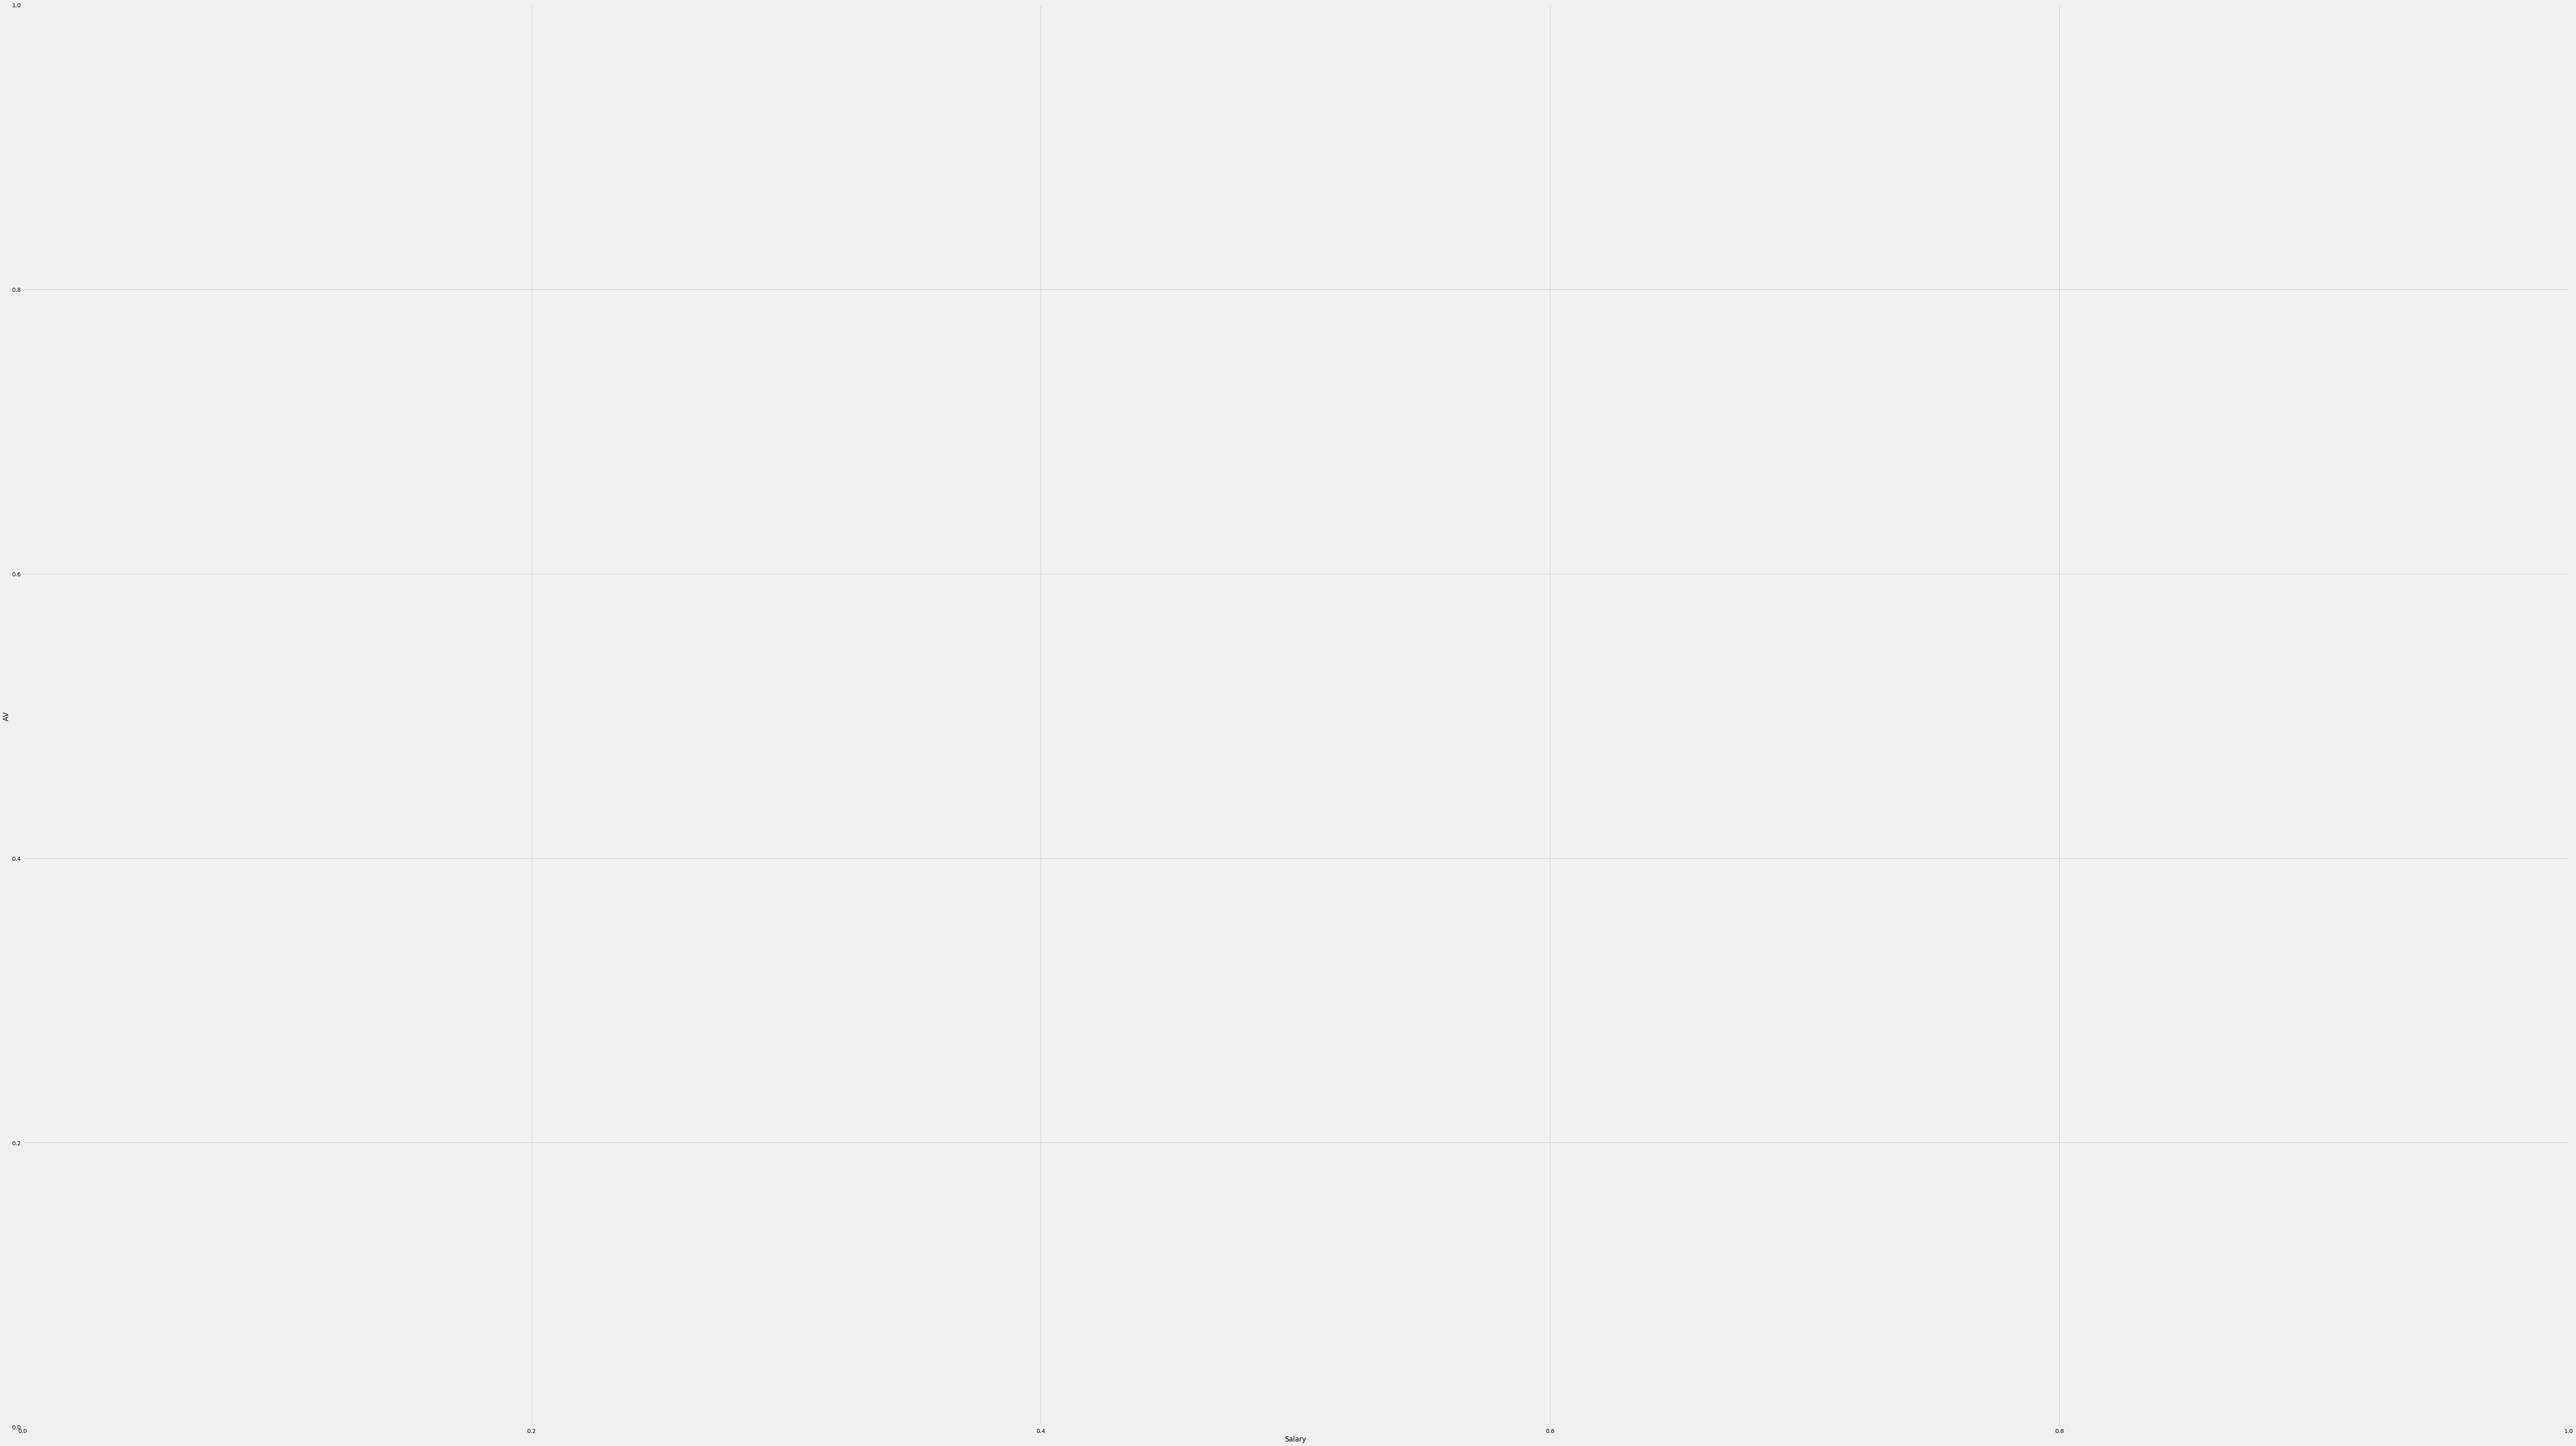

In [57]:
# TODO make plot

# USE GGPLOT FOR THIS 
fig = plt.figure(figsize=(100, 60))
#fig_h, axes_arr = plt.subplots(nrows=1, ncols=1, sharex=True)

x = Rush_2017['Salary Cap Value']
y = Rush_2017['AV']


plt.xlabel('Salary')
plt.ylabel('AV')



lp = plt.density(x,y) #training


count = 0
for x,y,z in zip(x, y, Rush_2017['Player']):
    
    label = z

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
    count = count + 1
    
    
plt.show()

#print("best C for LR with 2 feature data: %.3f" % best_c) # TODO

In [ ]:
sns.jointplot(x=Rush_2017['AAV'], y=Rush_2017['DYAR'], kind='kde')

# Look at RB data for Rookies RB's to figure out Average VORP/$

Then, I can plot that value for each rookie and see who outperformed contracts...

# Look at RB data for Free Agent Rb's to figure out VORP/$

This tool includes all signings that happen during the Free Agency window only. Spotrac.com data for all Salaries and Contract Information

For free agents, for performance average out the years of the deal, for money have some way to weight the size of the contract and look at guarenteed money

## Creation of WPVAR field in the data

PPOI (Positional Performance over income) = 0.5* AV + 0.3* DYAR + X(RBs, QBs, TEs, WRs... different)* O-line + 0.1* EYds + maybe another metric to guess performance / Salary Cap Value Z-Score(per position, so you can see relative pay at that position for that year) 

WPVAR = Positional constant (k) * (PPOI) / Average Joe PPOI   (This metric will put all players on an even playing field in terms of value per contracts), then I can cluster All players and see where players fall

Can also re-evaluate tiers of each skill positon and where they are peforming relatively for the money they make, which can then be used to inform how to spend for the coming season... free agency prices and estimates, draft considerations...

### Preparing Data for K-means clustering 
    Getting rid of fields that are not relevant for evaluating the RB's

## This k means will be to cluster players by performance

In [58]:
Kdata_RB_2017 = Rush_2017

print(Kdata_RB_2017)

train = Kdata_RB_2017.drop(['Player','Team_x','Team_y', 'Yards','Rk', 'Year', 'Draft', 'Tm', 'Lg', 'G', 'Yrs', 'PB', 'AP1',
                            'Salary Cap Value','Cash Spent'], axis=1)

#am i supposed to drop player?


train.info()

                          Player Team_x  DYAR  YAR   DVOA    VOA  Runs  Yards  \
0            Dion Lewis\LewiDi00     NE   273  280  0.276  0.286   180    896   
1           Todd Gurley\GurlTo01   LARM   268  205  0.139  0.086   279  1,305   
2          Alvin Kamara\KamaAl00     NO   255  255  0.445  0.444   120    728   
3           Kareem Hunt\HuntKa00     KC   222  248  0.119  0.143   272  1,327   
4          Le'Veon Bell\BellLe00    PIT   214  261  0.079  0.115   321  1,315   
5          Alex Collins\CollAl00    BAL   205  181  0.151  0.123   212    980   
6       Ezekiel Elliott\ElliEz00    DAL   205  198  0.111  0.105   242    983   
7           Mark Ingram\IngrMa01     NO   193  210  0.112  0.128   230  1,127   
8        Marshawn Lynch\LyncMa00    OAK   165  131  0.101  0.063   207    891   
9         Jordan Howard\HowaJo00    CHI   160  122  0.058  0.024   276  1,124   
10    Leonard Fournette\FourLe00    JAC   115   57  0.021 -0.033   268  1,040   
11      Jamaal Williams\Will

In [165]:
kmeans = KMeans(n_clusters= 6, random_state=0).fit(train)
ymeans = Kmeans.predict(test)
labels = kmeans.labels_
labels

NameError: name 'train' is not defined

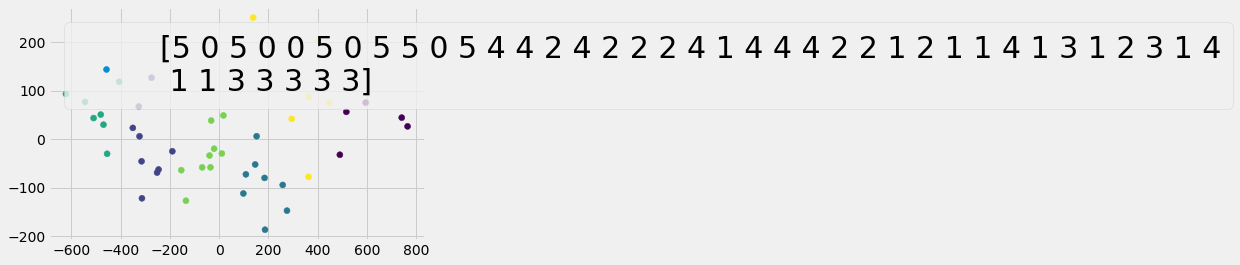

array([[ 4.04450762e+02,  2.03317379e+02, -1.17555364e+01,
         3.08025380e-01,  2.27226572e+00, -2.82670769e+00,
        -2.49134927e+00, -5.42223686e-01, -4.83131840e-01,
        -4.58409308e-03],
       [ 7.40834074e+02,  4.45881581e+01,  3.82350063e+01,
         1.98834918e-01, -3.39392180e-01,  1.52642932e+00,
         7.11111035e+00, -2.04217720e+00,  9.52889924e-01,
        -6.89776254e-02],
       [ 1.38175988e+02,  2.50598709e+02, -5.61743466e+00,
        -4.79742746e+00, -1.95779803e+00,  7.62922791e-02,
         3.50800274e+00, -1.53631489e-01, -3.68504236e-01,
         2.29887305e-01],
       [ 5.94705012e+02,  7.55696330e+01, -3.05281365e+01,
        -9.11597863e+00, -1.04714570e+00,  2.15265196e+00,
         6.19079478e-01, -6.52320227e-01, -8.75207582e-01,
        -6.09442675e-02],
       [ 7.64565075e+02,  2.66139023e+01, -4.66063495e+01,
        -5.44585814e+00, -2.76376454e+00, -2.40495213e+00,
         4.97185067e-01, -2.75121661e-01,  1.45950143e-01,
        -8.

In [69]:
from sklearn.decomposition import PCA
pca_2 = PCA('mle')
plot_columns = pca_2.fit_transform(train)

plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels, label = labels)
plt.legend(loc=2, prop={'size': 30})

plt.show()

plot_columns

In [150]:
fig = plt.figure(figsize=(50, 25))

xs = np.array(x)
ys = np.array(y)
labels = np.array(round_picked)

Avg_DYAR = statistics.mean(y)
print(Avg_DYAR)


labels_masks =( (x,(labels == x)) for x in set(labels))
data_dict = dict( (lbl,(xs[mask],ys[mask])) for lbl,mask in labels_masks )

print(labels_masks)




label_dict = {1: 'r', 2: 'b', 3: 'g', 4: 'lime', 5:'pink', 6:'orange', 7:'indigo'}
legend_dict = {1: 'Round 1', 2: 'Round 2', 3: 'Round 3', 4: 'Round 4', 5:'Round 5', 6:'Round 6', 7:'Round 7'}

for label,data in data_dict.items():
    x,y = data
    plt.scatter(x,y,c=label_dict.get(label),label=legend_dict.get(label), s = 250)

plt.legend(loc=2, prop={'size': 30})
plt.title('NFL Rookie Running Backs (2015-2018) DYAR vs. AAV', fontsize = 40)
plt.xlabel('AAV', fontsize=40)
plt.ylabel('DYAR', fontsize=40)

plt.axvline(x=lowest_sal_16, color='g', linestyle='--')
plt.axhline(y = 0, color='k', linestyle='--')

plt.savefig('Rookie_RB.png')

plt.show()

-1.1


IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 78

<Figure size 3600x1800 with 0 Axes>

In [61]:
cluster_labels = []

for i,ele in enumerate(Kdata_RB_2017['Player']):
    X = train.loc[ Kdata_RB_2017['Player'] == ele,: ]
    
    X_list = X.values.tolist()
    
    X_Cluster_Label = kmeans.predict(X_list)
    
    print(ele, "   ", X_Cluster_Label)
    
    if X_Cluster_Label not in cluster_labels:
        cluster_labels.append(X_Cluster_Label)
    

Dion Lewis\LewiDi00     [5]
Todd Gurley\GurlTo01     [0]
Alvin Kamara\KamaAl00     [5]
Kareem Hunt\HuntKa00     [0]
Le'Veon Bell\BellLe00     [0]
Alex Collins\CollAl00     [5]
Ezekiel Elliott\ElliEz00     [0]
Mark Ingram\IngrMa01     [5]
Marshawn Lynch\LyncMa00     [5]
Jordan Howard\HowaJo00     [0]
Leonard Fournette\FourLe00     [5]
Jamaal Williams\WillJa06     [4]
Javorius Allen\AlleJa01     [4]
Devonta Freeman\FreeDe00     [2]
Joe Mixon\MixoJo00     [4]
Frank Gore\GoreFr00     [2]
Latavius Murray\MurrLa00     [2]
Lamar Miller\MillLa01     [2]
Derrick Henry\HenrDe00     [4]
Giovani Bernard\BernGi00     [1]
Isaiah Crowell\CrowIs00     [4]
Jay Ajayi\AjayJa00     [4]
DeMarco Murray\MurrDe00     [4]
Melvin Gordon\GordMe00     [2]
C.J. Anderson\AndeC.00     [2]
Tevin Coleman\ColeTe01     [1]
Carlos Hyde\HydeCa00     [2]
Christian McCaffrey\McCaCh01     [1]
Ameer Abdullah\AbduAm00     [1]
LeGarrette Blount\BlouLe00     [4]
Kenyan Drake\DrakKe00     [1]
Matt Forte\FortMa00     [3]
Jerick Mc

In [ ]:
from sklearn.decomposition import PCA
pca_2 = PCA('mle')
plot_columns = pca_2.fit_transform(train)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']



plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1],c = labels)
               
#plt.legend()

# use GGPLOT2


plt.show()

## This k means will be to cluster players by salary

## This k means will be to cluster players by WPVAR

Choose a flew players to highlight in the clusters and explain the trends that are visible

In [ ]:
#Find the 'good columns' data for the player LeBron James
#again by 'good columns' I mean with only numeric values, and no missing values (NA, Nan, etc).

# Find player LeBron

    
    
    

# Gurley = train.loc[ Kdata_RB_2017['Player'] == 'Todd Gurley\GurlTo01',: ]

#print(Gurley)

#Find player Durant
Mixon = train.loc[ Kdata_RB_2017['Player'] == 'Matt Breida\BreiMa00',: ]

#print the players
#print(Gurley)
print(Mixon)

# ----------------------------------------------------------------

# 2017 Receiving Data Merging to get AV in same table 

In [ ]:
#Rushing_2017
Rec_2017 = Receiving_2017.merge(AV_2017, how='left',on='Player')

# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
indexNames = Rec_2017[Rec_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
Rec_2017.drop(indexNames , inplace=True)
Rec_2017.sort_values(by=['AV'], ascending=False)

In [ ]:
# Passing 2017
Pass_2017 = Passing_2017.merge(AV_2017, how='left',on='Player')

# Cuttoff for AV is 5, if you are worse than that, you probably don't have any impact 
indexNames = Pass_2017[Pass_2017['AV'] < 5.0].index
 
# Delete these row indexes from dataFrame
Pass_2017.drop(indexNames , inplace=True)
Pass_2017.sort_values(by=['AV'], ascending=False)

## 2018

In [ ]:
#Rushing_2018
RB_2018 = Rushing_2017.merge(AV_2018, how='left',on='Player')
RB_2018.sort_values(by=['AV'], ascending=False)